# Introduction  #

To predict future store sales of different product families using time-series ML techniques

# **1. Read in Input and Basic Analysis**

In [1]:
# setup notebook
from pathlib import Path
import pandas as pd

# Read in raw train data and test data
comp_dir = Path('../input/store-sales-time-series-forecasting')

train_raw = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
train_raw['date'] = train_raw.date.dt.to_period('D')
train_raw = train_raw.set_index(['store_nbr', 'family', 'date']).sort_index()

test_raw = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test_raw['date'] = test_raw.date.dt.to_period('D')
test_raw = test_raw.set_index(['store_nbr', 'family', 'date']).sort_index()

In [2]:
# Take a look at the raw train data
train_raw

sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]

**Note:** Raw training data contains 'sales' and 'onpromotion' information for 54 stores, 33 product families and 1684 dates.

In [3]:
# Take a look at the raw test data
test_raw

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

**Note:** Raw testing data contains 'id' and 'onpromotion' information for 54 stores, 33 product families and 16 dates right after training data date ends. Task is to predict 'sales' for the testing data.

# 2. Identify the Forecasting Task

The training data ends on *2017-08-15* which is the forcast origin. The testing data starts on *2017-08-16* and ends on *2017-08-31*, which is the forecast horizon. Therefore, a 16-step forecast with 1-step lead time is the task.

# 3. EDA of Train Data

## 3.1. Sale Trend Exploration

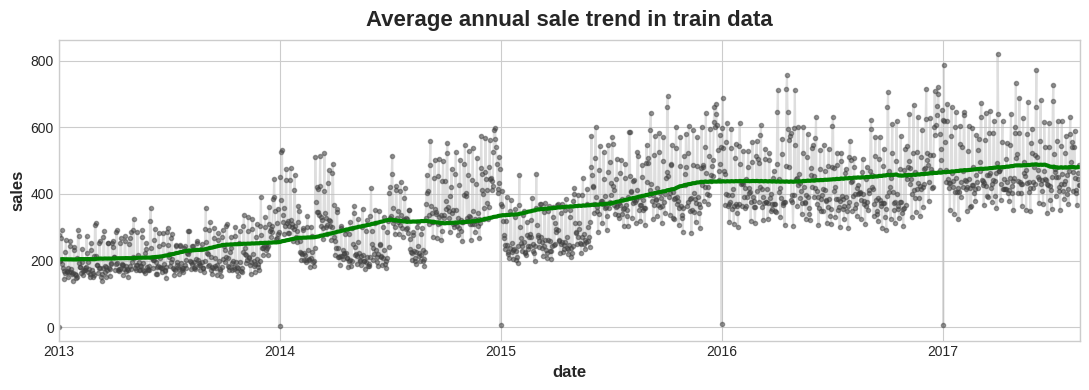

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from learntools.time_series.style import *
%matplotlib inline

# plot total average sale trend for train data (total -> mean of all stores and families)
total_avg_sales = train_raw.groupby('date').mean()['sales']
total_anu_trend = total_avg_sales.rolling(window = 365, center = True, min_periods = 185).mean()

ax = total_avg_sales.plot(**plot_params, alpha = 0.5)
total_anu_trend.plot(ax = ax, linewidth = 3, color = 'green')

ax.set(title = 'Average annual sale trend in train data', ylabel = 'sales')
plt.show()

In [5]:
# get unique values for 'family' and 'store_nbr'
train_raw_sale = train_raw.unstack(['family', 'store_nbr'])['sales']
train_famstr_list = train_raw_sale.columns
fam_list = []
store_list = []
for i in range (len(train_famstr_list)):
    famstr_pair = list(train_famstr_list[i])
    fam = famstr_pair[0]
    store = famstr_pair[1]
    fam_list.append(fam)
    store_list.append(store)

fam_list = set(fam_list)
store_list = set(store_list)
    
print(fam_list)
print(store_list)

{'SCHOOL AND OFFICE SUPPLIES', 'GROCERY I', 'GROCERY II', 'PREPARED FOODS', 'EGGS', 'SEAFOOD', 'PRODUCE', 'CLEANING', 'BOOKS', 'PET SUPPLIES', 'DELI', 'FROZEN FOODS', 'BEAUTY', 'BEVERAGES', 'AUTOMOTIVE', 'HOME AND KITCHEN II', 'HOME CARE', 'BREAD/BAKERY', 'BABY CARE', 'PERSONAL CARE', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'DAIRY', 'LAWN AND GARDEN', 'HOME APPLIANCES', 'LADIESWEAR', 'LIQUOR,WINE,BEER', 'MEATS', 'MAGAZINES', 'CELEBRATION', 'LINGERIE', 'HARDWARE', 'HOME AND KITCHEN I'}
{'17', '4', '51', '39', '16', '47', '50', '44', '46', '3', '27', '34', '15', '31', '40', '5', '52', '10', '32', '35', '18', '49', '6', '25', '43', '7', '20', '48', '12', '41', '38', '22', '53', '1', '8', '28', '14', '11', '2', '24', '19', '9', '29', '45', '42', '36', '33', '13', '21', '37', '30', '54', '23', '26'}


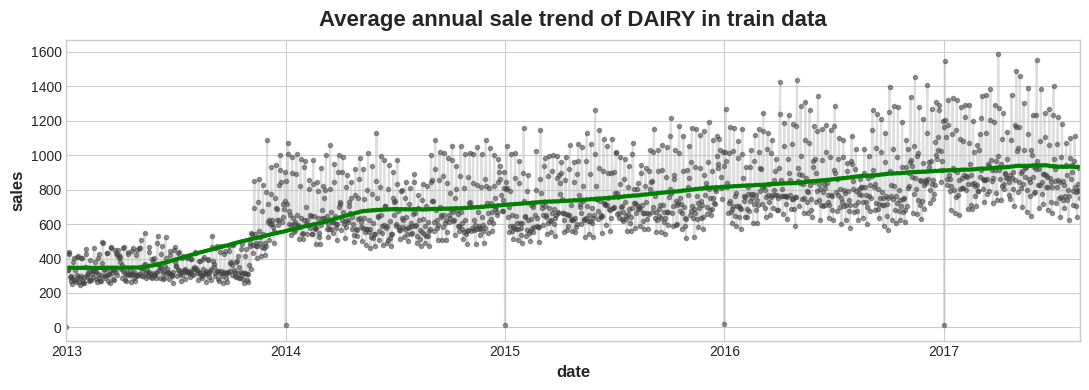

In [6]:
# plot store-average product sale trend of selected family
fam = 'DAIRY'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
anu_trend = avg_sales.rolling(window = 365, center = True, min_periods = 185).mean()
ax = avg_sales.plot(**plot_params, alpha = 0.5)
anu_trend.plot(ax = ax, linewidth = 3, color = 'green')
ax.set(title = f"Average annual sale trend of %s in train data" %fam, ylabel = 'sales')
plt.show()

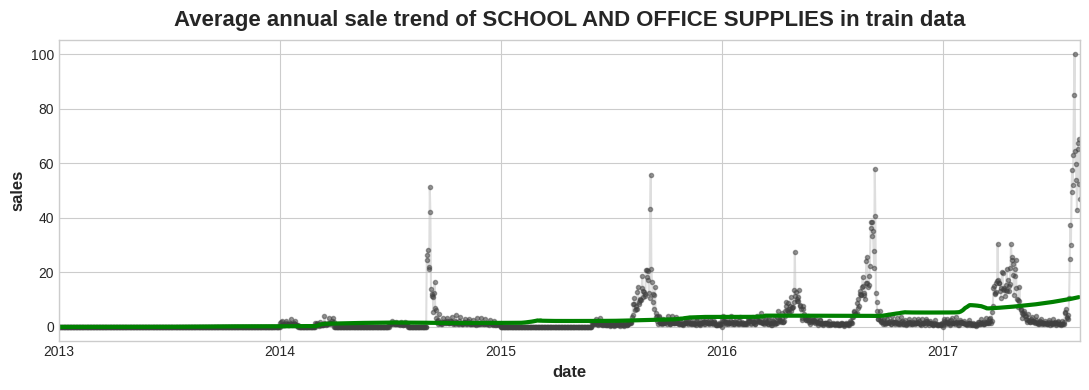

In [7]:
# plot store-average product sale trend of selected family
fam = 'SCHOOL AND OFFICE SUPPLIES'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
anu_trend = avg_sales.rolling(window = 365, center = True, min_periods = 185).mean()
ax = avg_sales.plot(**plot_params, alpha = 0.5)
anu_trend.plot(ax = ax, linewidth = 3, color = 'green')
ax.set(title = f"Average annual sale trend of %s in train data" %fam, ylabel = 'sales')
plt.show()

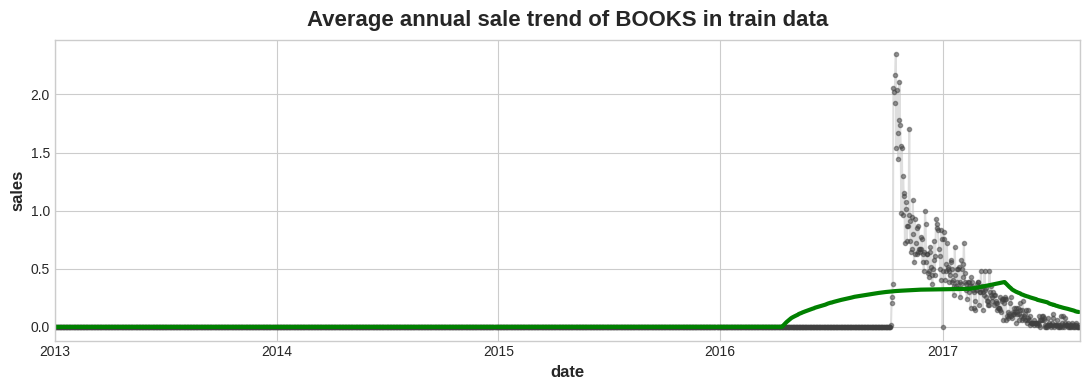

In [8]:
# plot store-average product sale trend of selected family
fam = 'BOOKS'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
anu_trend = avg_sales.rolling(window = 365, center = True, min_periods = 185).mean()
ax = avg_sales.plot(**plot_params, alpha = 0.5)
anu_trend.plot(ax = ax, linewidth = 3, color = 'green')
ax.set(title = f"Average annual sale trend of %s in train data" %fam, ylabel = 'sales')
plt.show()

## 3.2. Seasonal Pattern Exploration
Besides the general trend discoverd in the previous section, there are seasonal patterns potentially in the train data.

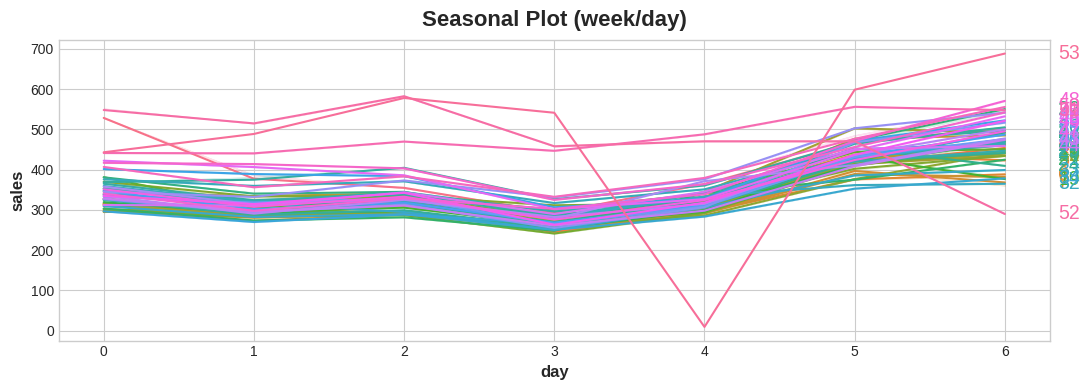

In [9]:
from learntools.time_series.utils import seasonal_plot, plot_periodogram

# plot total average sale weekly pattern for train data (total -> mean of all stores and families)
total_avg_sales_df = total_avg_sales.to_frame()
total_avg_sales_df['week'] = total_avg_sales_df.index.week
total_avg_sales_df['day'] = total_avg_sales_df.index.dayofweek

seasonal_plot(total_avg_sales_df, y = 'sales', period = 'week', freq = 'day')
plt.show()

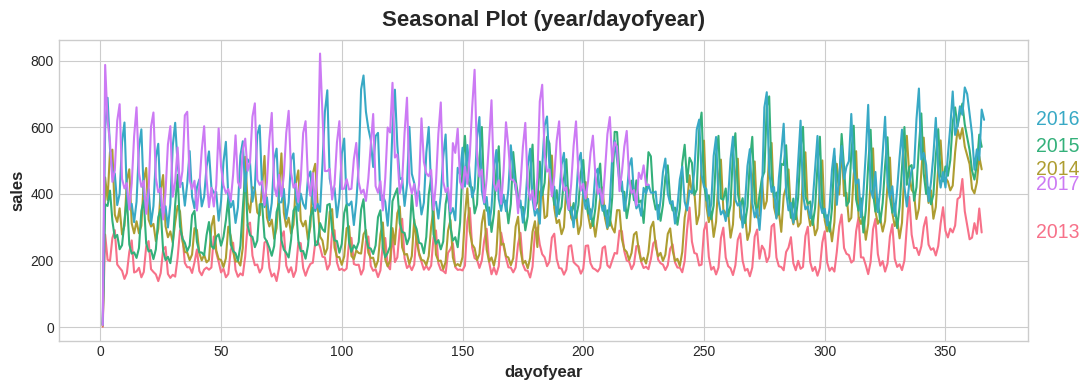

In [10]:
# plot total average sale annual pattern for train data (total -> mean of all stores and families)
total_avg_sales_df['year'] = total_avg_sales_df.index.year
total_avg_sales_df['dayofyear'] = total_avg_sales_df.index.dayofyear

seasonal_plot(total_avg_sales_df, y = 'sales', period = 'year', freq = 'dayofyear')
plt.show()

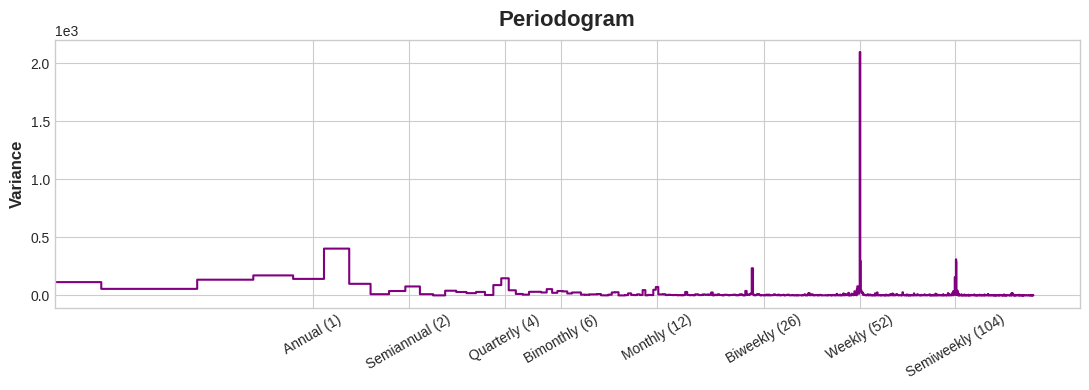

In [11]:
# plot total average sale periodogram for train data (total -> mean of all stores and families)
from learntools.time_series.utils import plot_periodogram
plot_periodogram(total_avg_sales)
plt.show()

**Note:**
* The total average sale demonstrates obvious weekly seasonal patterns.
* Annual season is also observed for total average sale. Though the trend is similar, there are variations among different years.
* From Periodogram, to capture long seasons, 4 Fourier pairs are required since the periodogram drops off after Quarterly ignoring the short seasons (Biweekly, Weekly, Semiweekly).

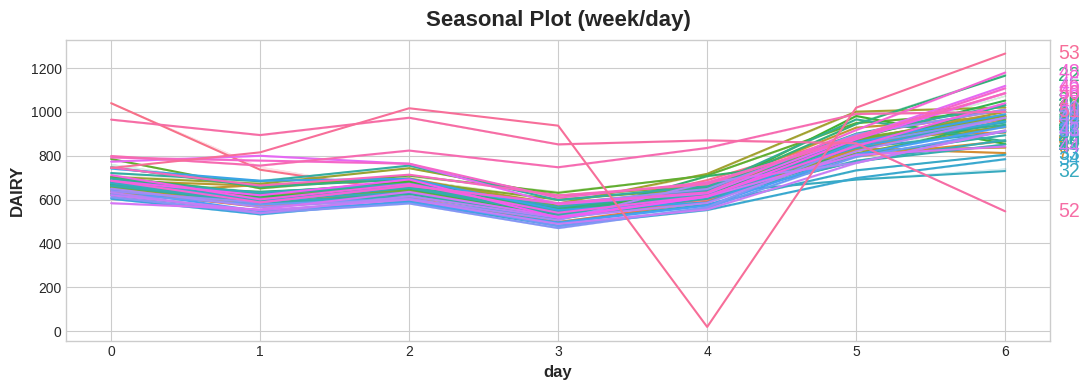

In [12]:
# plot store-average product sale weekly pattern of selected family
fam = 'DAIRY'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
avg_sales_df = avg_sales.to_frame()
avg_sales_df['week'] = avg_sales_df.index.week
avg_sales_df['day'] = avg_sales_df.index.dayofweek

seasonal_plot(avg_sales_df, y = fam, period = 'week', freq = 'day')
plt.show()

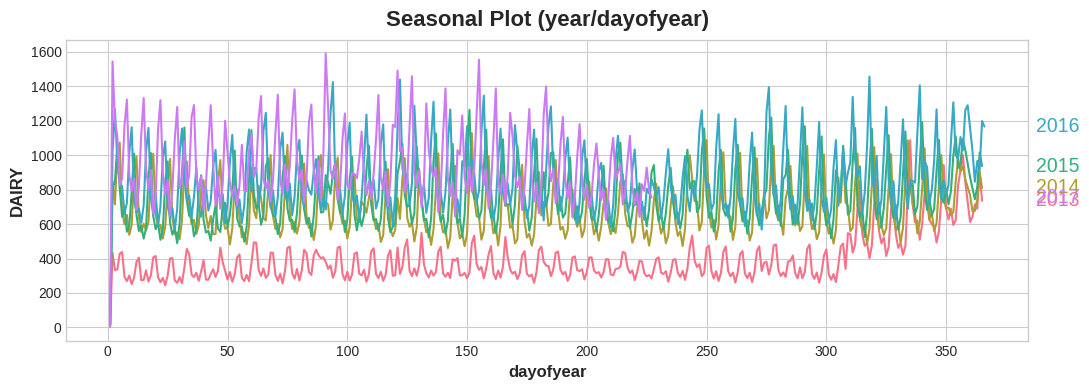

In [13]:
# plot store-average product sale annual pattern of selected family
avg_sales_df['year'] = avg_sales_df.index.year
avg_sales_df['dayofyear'] = avg_sales_df.index.dayofyear

seasonal_plot(avg_sales_df, y = fam, period = 'year', freq = 'dayofyear')
plt.show()

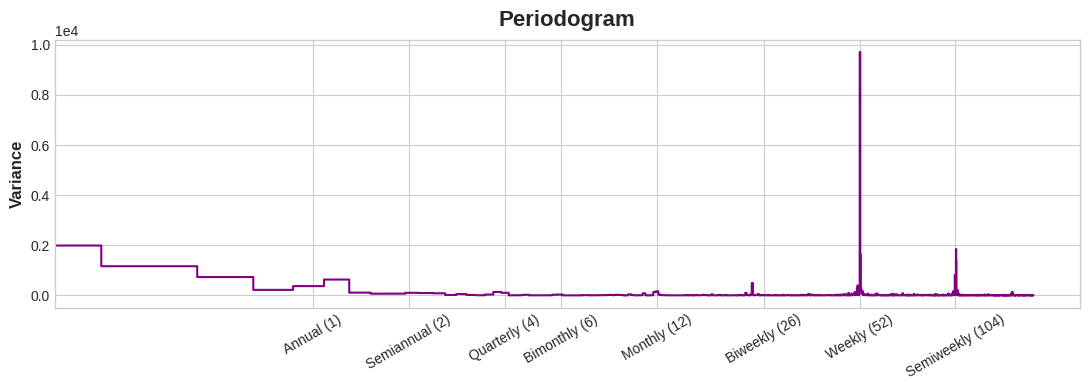

In [14]:
# plot store-average product sale periodogram for train data of selected family
plot_periodogram(avg_sales)
plt.show()

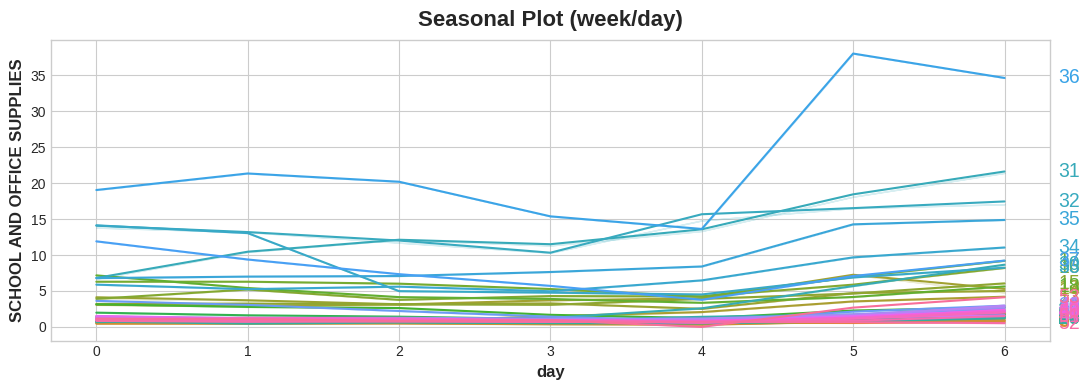

In [15]:
# plot store-average product sale seasonal pattern of selected family
fam = 'SCHOOL AND OFFICE SUPPLIES'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
avg_sales_df = avg_sales.to_frame()
avg_sales_df['week'] = avg_sales_df.index.week
avg_sales_df['day'] = avg_sales_df.index.dayofweek

seasonal_plot(avg_sales_df, y = fam, period = 'week', freq = 'day')
plt.show()

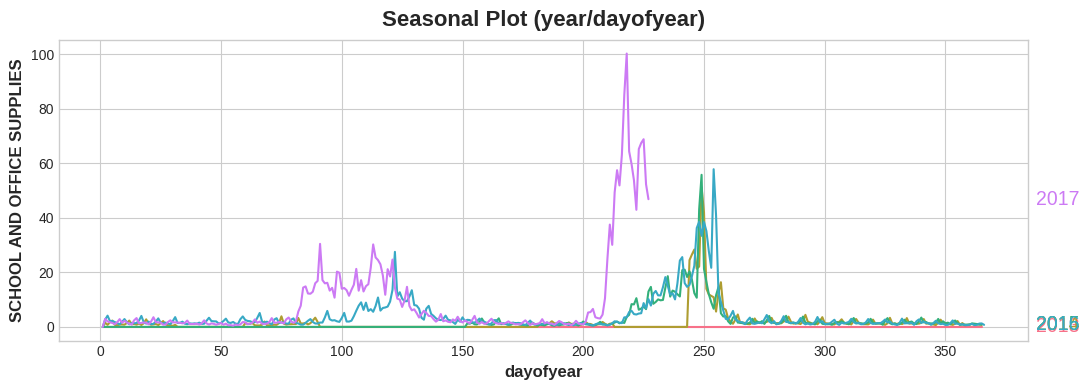

In [16]:
# plot store-average product sale annual pattern of selected family
avg_sales_df['year'] = avg_sales_df.index.year
avg_sales_df['dayofyear'] = avg_sales_df.index.dayofyear

seasonal_plot(avg_sales_df, y = fam, period = 'year', freq = 'dayofyear')
plt.show()

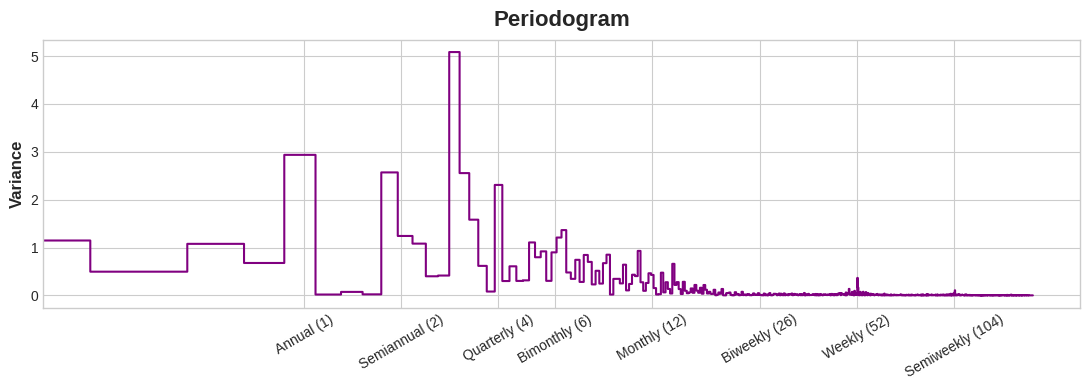

In [17]:
# plot store-average product sale periodogram for train data of selected family
plot_periodogram(avg_sales)
plt.show()

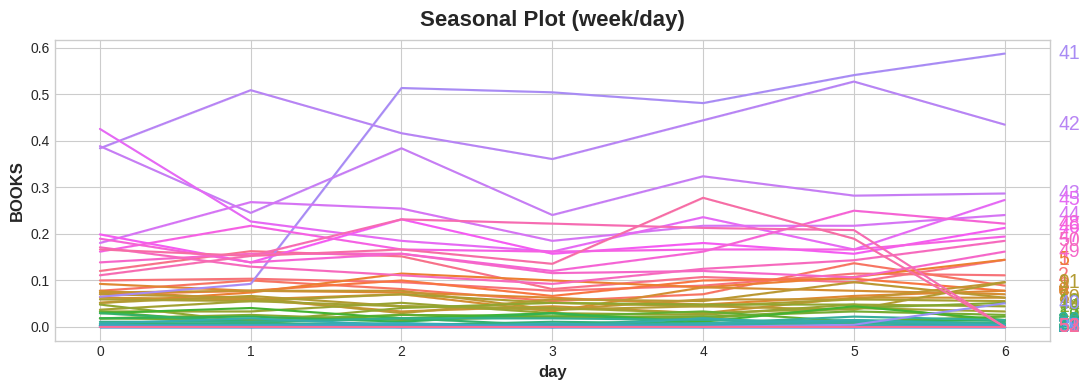

In [18]:
# plot store-average product sale seasonal pattern of selected family
fam = 'BOOKS'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
avg_sales_df = avg_sales.to_frame()
avg_sales_df['week'] = avg_sales_df.index.week
avg_sales_df['day'] = avg_sales_df.index.dayofweek

seasonal_plot(avg_sales_df, y = fam, period = 'week', freq = 'day')
plt.show()

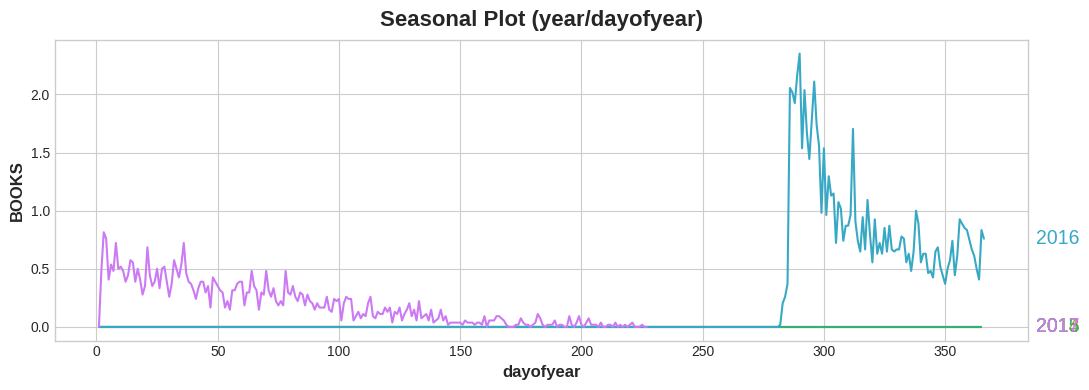

In [19]:
# plot store-average product sale annual pattern of selected family
avg_sales_df['year'] = avg_sales_df.index.year
avg_sales_df['dayofyear'] = avg_sales_df.index.dayofyear

seasonal_plot(avg_sales_df, y = fam, period = 'year', freq = 'dayofyear')
plt.show()

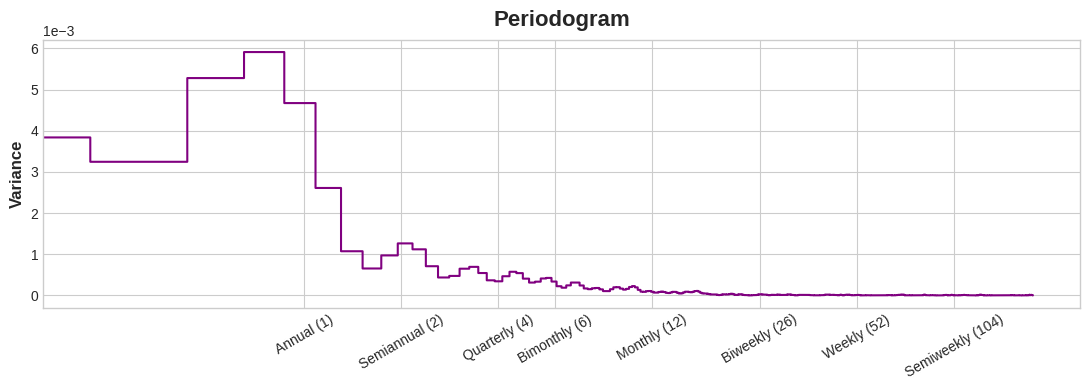

In [20]:
# plot store-average product sale periodogram for train data of selected family
plot_periodogram(avg_sales)
plt.show()

**Note:**
* From various seasonal plots of total average sale and store-average sales of individual product family, short weekly season is observed for the majority of the data. Weekly seasonal indicators are required for forecasting.
* From annual seasonal plots and periodogram, long season is observed and Fourier features are required for forecasting. We can try 4 pairs first from total average sale plot. Then try 12 pairs (required by some families, such as 'SCHOOL AND OFFICE SUPPLIES') to see if there is any improvements.

## 3.3. Plotting Cycle

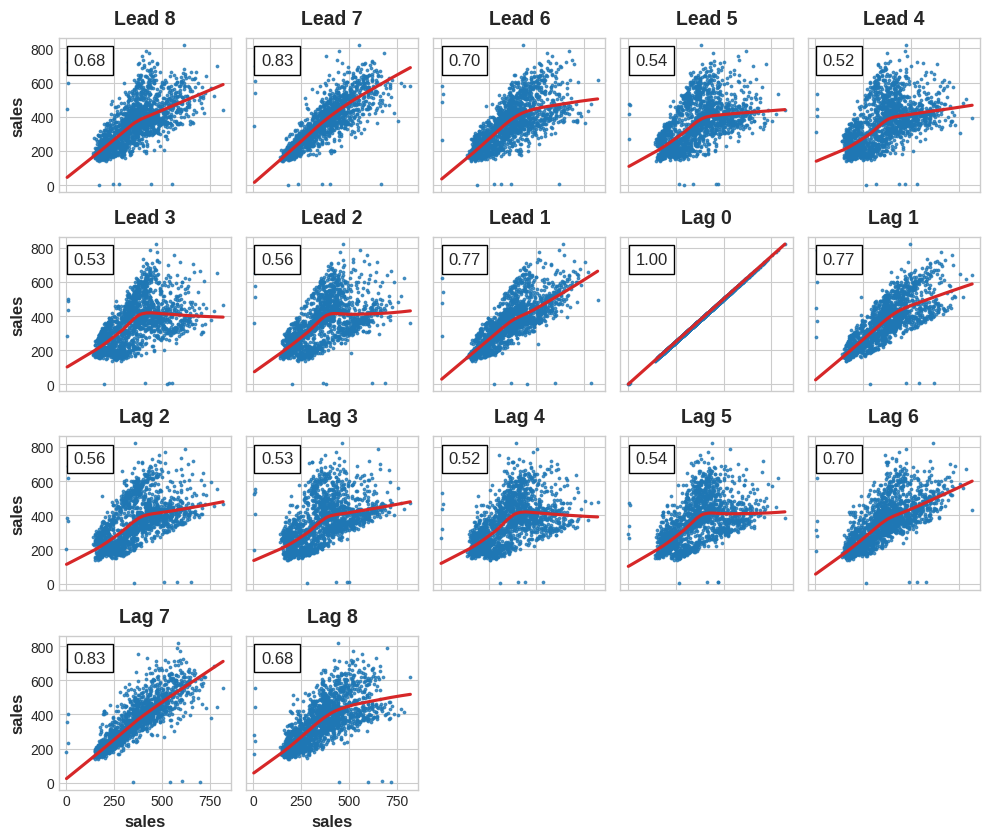

In [21]:
from learntools.time_series.utils import plot_lags, make_lags, make_leads

# plot total average sale vs lags for train data (total -> mean of all stores and families)
plot_lags(total_avg_sales, lags = 8, leads = 8, nrows = 4)
plt.show()

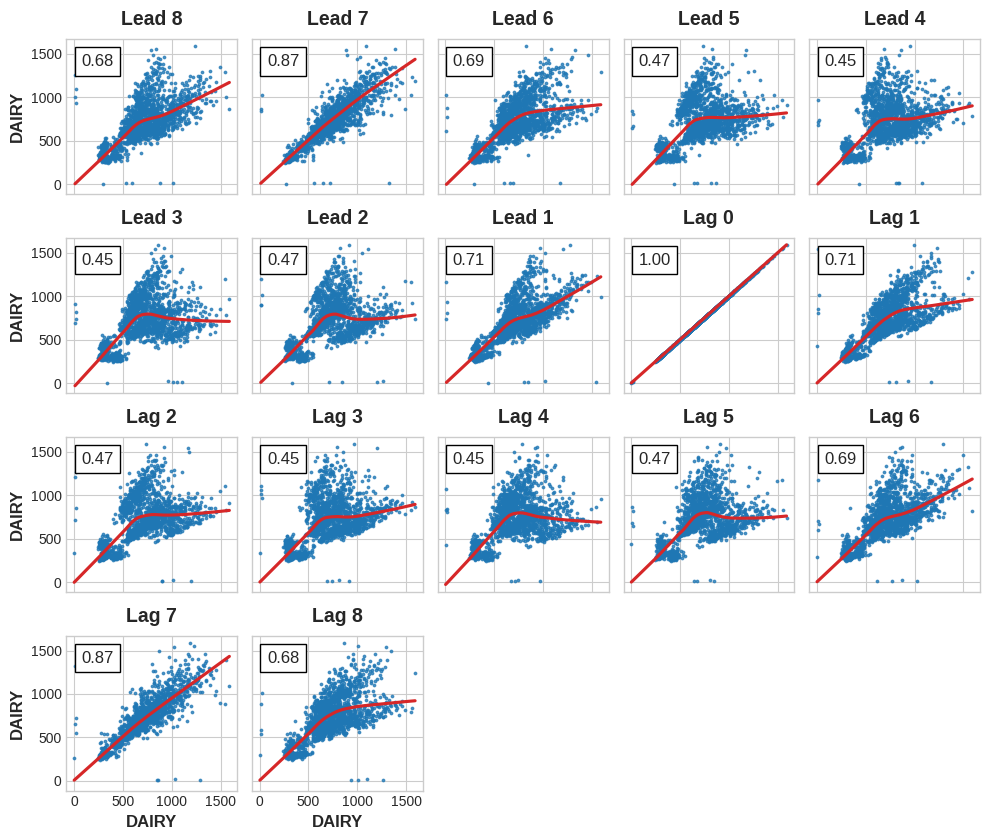

In [22]:
# plot store-average product sale vs lags of selected family
fam = 'DAIRY'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
plot_lags(avg_sales, lags = 8, leads = 8, nrows = 4)
plt.show()

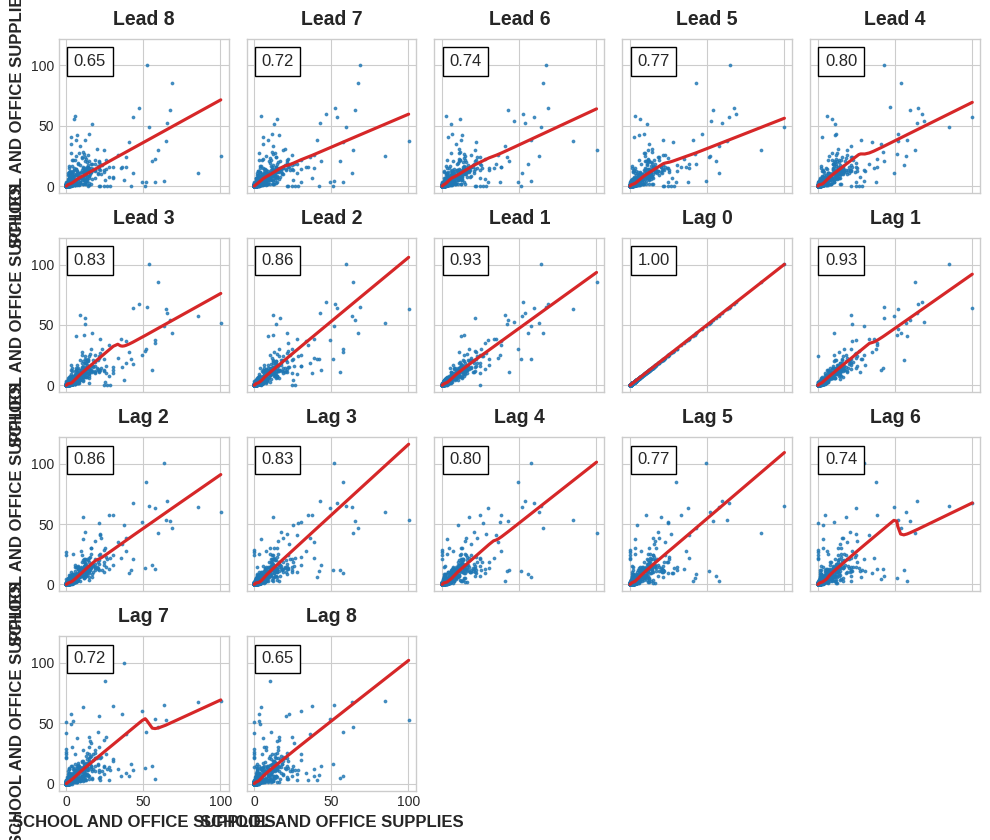

In [23]:
# plot store-average product sale vs lags of selected family
fam = 'SCHOOL AND OFFICE SUPPLIES'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
plot_lags(avg_sales, lags = 8, leads = 8, nrows = 4)
plt.show()

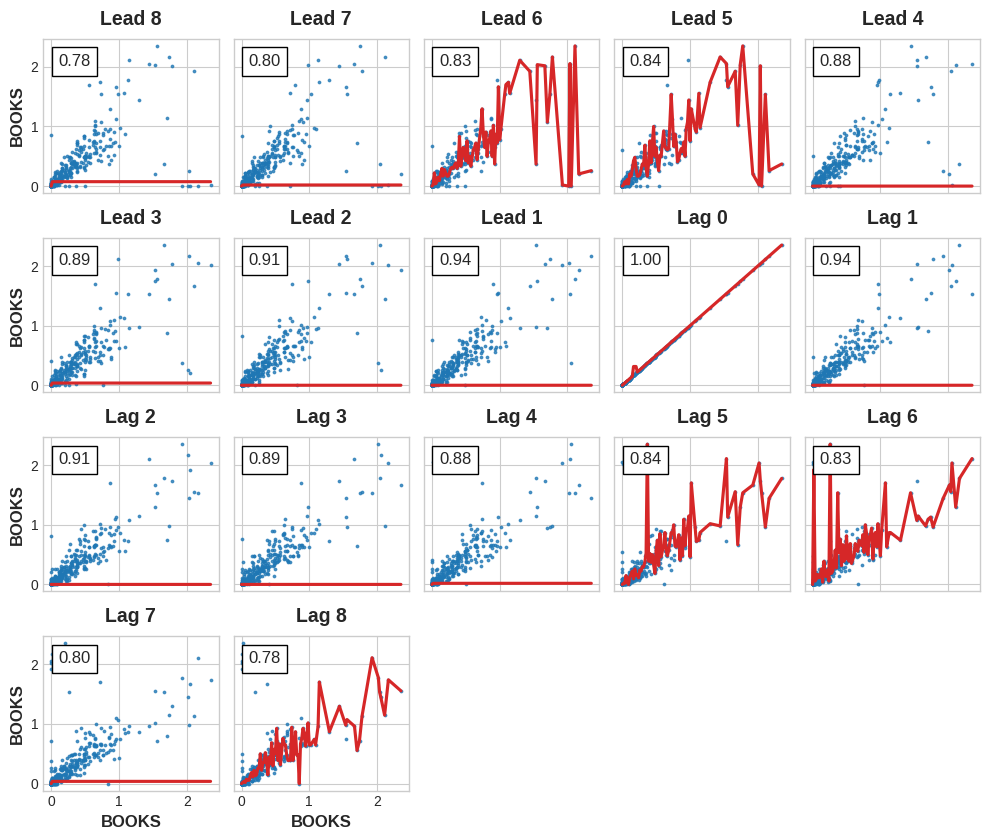

In [24]:
# plot store-average product sale vs lags of selected family
fam = 'BOOKS'
avg_sales = train_raw_sale.stack('store_nbr').groupby('date').mean()[fam]
plot_lags(avg_sales, lags = 8, leads = 8, nrows = 4)
plt.show()

**Note:**
* From lag plot, the relationship between average sale and its lags is non-linear. 
* Can ignore them for 1st round linear regression and check residuals lag plots later.
* From EDA, majority products share similar trends and seasons for sales. Linear regression with proper time-dependent features should be able to predict such trends and seasons.
* However, there are individual product family having different trend and seasons. Can use a different model to model the residuals after linear regression.
* Ensembling the two models to a hybrid model for forecasting of test data seems a better choice.

# 4. Feature Engineering

## 4.1. Trend and Seasonal Features (time indicators)
A time indicator is derived only from 'date'.

**In the previous versions, it is found that 4 Fourier pairs works better than 12 Fourier pairs.**

In [25]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# create Fourier features to capture long seasons
fourier_pair = 4
fourier = CalendarFourier(freq = 'M', order = fourier_pair)

# create simple trend indicator, weekly seasonal indicators and incorporate Fourier features
dp = DeterministicProcess(index = total_avg_sales.index, 
                          constant = True, 
                          order = 1, 
                          seasonal = True, 
                          additional_terms = [fourier], 
                          drop = True)
X_1 = dp.in_sample()

In [26]:
X_1

const   trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                        
2013-01-01    1.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2013-01-02    1.0     2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2013-01-03    1.0     3.0     0.0     1.0     0.0     0.0     0.0     0.0   
2013-01-04    1.0     4.0     0.0     0.0     1.0     0.0     0.0     0.0   
2013-01-05    1.0     5.0     0.0     0.0     0.0     1.0     0.0     0.0   
...           ...     ...     ...     ...     ...     ...     ...     ...   
2017-08-11    1.0  1680.0     0.0     0.0     0.0     0.0     0.0     1.0   
2017-08-12    1.0  1681.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-08-13    1.0  1682.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-14    1.0  1683.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0  1684.0     0.0     0.0     1.0     0.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2013-01-01       0.000000       1.000000       0.000000       1.000000   
2013-01-02       0.201299       0.979530       0.394356       0.918958   
2013-01-03       0.394356       0.918958       0.724793       0.688967   
2013-01-04       0.571268       0.820763       0.937752       0.347305   
2013-01-05       0.724793       0.688967       0.998717      -0.050649   
...                   ...            ...            ...            ...   
2017-08-11       0.897805      -0.440394      -0.790776      -0.612106   
2017-08-12       0.790776      -0.612106      -0.968077      -0.250653   
2017-08-13       0.651372      -0.758758      -0.988468       0.151428   
2017-08-14       0.485302      -0.874347      -0.848644       0.528964   
2017-08-15       0.299363      -0.954139      -0.571268       0.820763   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  
date                                                                    
2013-01-01       0.000000       1.000000       0.000000       1.000000  
2013-01-02       0.571268       0.820763       0.724793       0.688967  
2013-01-03       0.937752       0.347305       0.998717      -0.050649  
2013-01-04       0.968077      -0.250653       0.651372      -0.758758  
2013-01-05       0.651372      -0.758758      -0.101168      -0.994869  
...                   ...            ...            ...            ...  
2017-08-11      -0.201299       0.979530       0.968077      -0.250653  
2017-08-12       0.394356       0.918958       0.485302      -0.874347  
2017-08-13       0.848644       0.528964      -0.299363      -0.954139  
2017-08-14       0.998717      -0.050649      -0.897805      -0.440394  
2017-08-15       0.790776      -0.612106      -0.937752       0.347305  

[1684 rows x 16 columns]

In [27]:
X_1_test = dp.out_of_sample(steps = 16)
X_1_test.index.allname = 'date'
X_1_test

const   trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
2017-08-16    1.0  1685.0     0.0     0.0     0.0     1.0     0.0     0.0   
2017-08-17    1.0  1686.0     0.0     0.0     0.0     0.0     1.0     0.0   
2017-08-18    1.0  1687.0     0.0     0.0     0.0     0.0     0.0     1.0   
2017-08-19    1.0  1688.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-08-20    1.0  1689.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-21    1.0  1690.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-22    1.0  1691.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-08-23    1.0  1692.0     0.0     0.0     0.0     1.0     0.0     0.0   
2017-08-24    1.0  1693.0     0.0     0.0     0.0     0.0     1.0     0.0   
2017-08-25    1.0  1694.0     0.0     0.0     0.0     0.0     0.0     1.0   
2017-08-26    1.0  1695.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-08-27    1.0  1696.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-28    1.0  1697.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-29    1.0  1698.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-08-30    1.0  1699.0     0.0     0.0     0.0     1.0     0.0     0.0   
2017-08-31    1.0  1700.0     0.0     0.0     0.0     0.0     1.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
2017-08-16       0.101168      -0.994869      -0.201299       0.979530   
2017-08-17      -0.101168      -0.994869       0.201299       0.979530   
2017-08-18      -0.299363      -0.954139       0.571268       0.820763   
2017-08-19      -0.485302      -0.874347       0.848644       0.528964   
2017-08-20      -0.651372      -0.758758       0.988468       0.151428   
2017-08-21      -0.790776      -0.612106       0.968077      -0.250653   
2017-08-22      -0.897805      -0.440394       0.790776      -0.612106   
2017-08-23      -0.968077      -0.250653       0.485302      -0.874347   
2017-08-24      -0.998717      -0.050649       0.101168      -0.994869   
2017-08-25      -0.988468       0.151428      -0.299363      -0.954139   
2017-08-26      -0.937752       0.347305      -0.651372      -0.758758   
2017-08-27      -0.848644       0.528964      -0.897805      -0.440394   
2017-08-28      -0.724793       0.688967      -0.998717      -0.050649   
2017-08-29      -0.571268       0.820763      -0.937752       0.347305   
2017-08-30      -0.394356       0.918958      -0.724793       0.688967   
2017-08-31      -0.201299       0.979530      -0.394356       0.918958   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  
2017-08-16       0.299363      -0.954139      -0.394356       0.918958  
2017-08-17      -0.299363      -0.954139       0.394356       0.918958  
2017-08-18      -0.790776      -0.612106       0.937752       0.347305  
2017-08-19      -0.998717      -0.050649       0.897805      -0.440394  
2017-08-20      -0.848644       0.528964       0.299363      -0.954139  
2017-08-21      -0.394356       0.918958      -0.485302      -0.874347  
2017-08-22       0.201299       0.979530      -0.968077      -0.250653  
2017-08-23       0.724793       0.688967      -0.848644       0.528964  
2017-08-24       0.988468       0.151428      -0.201299       0.979530  
2017-08-25       0.897805      -0.440394       0.571268       0.820763  
2017-08-26       0.485302      -0.874347       0.988468       0.151428  
2017-08-27      -0.101168      -0.994869       0.790776      -0.612106  
2017-08-28      -0.651372      -0.758758       0.101168      -0.994869  
2017-08-29      -0.968077      -0.250653      -0.651372      -0.758758  
2017-08-30      -0.937752       0.347305      -0.998717      -0.050649  
2017-08-31      -0.571268       0.820763      -0.724793       0.688967

## 4.2. Create Holiday Features (time indicators)
Incorporate holiday information should help with sale forecasting since people tends to buy more stuff during holidays.

In [28]:
# read in holiday file
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events

type    locale locale_name                    description  \
date                                                                          
2012-03-02     Holiday     Local       Manta             Fundacion de Manta   
2012-04-01     Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2012-04-12     Holiday     Local      Cuenca            Fundacion de Cuenca   
2012-04-14     Holiday     Local    Libertad      Cantonizacion de Libertad   
2012-04-21     Holiday     Local    Riobamba      Cantonizacion de Riobamba   
...                ...       ...         ...                            ...   
2017-12-22  Additional  National     Ecuador                      Navidad-3   
2017-12-23  Additional  National     Ecuador                      Navidad-2   
2017-12-24  Additional  National     Ecuador                      Navidad-1   
2017-12-25     Holiday  National     Ecuador                        Navidad   
2017-12-26  Additional  National     Ecuador                      Navidad+1   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False  
2012-04-12        False  
2012-04-14        False  
2012-04-21        False  
...                 ...  
2017-12-22        False  
2017-12-23        False  
2017-12-24        False  
2017-12-25        False  
2017-12-26        False  

[350 rows x 5 columns]

In [29]:
# extract unique national and regional holidays in a single year
uniq_holidays = holidays_events.query("locale in ['National','Regional']").loc['2017':'2018',['description']]
uniq_holidays

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia
2017-10-09              Independencia de Guayaquil
2017-11-02                         Dia de Difuntos
2017-11-03                 Independencia de Cuenca
2017-11-06      Provincializacion de Santo Domingo
2017-11-07           Provincializacion Santa Elena
2017-12-21                               Navidad-4
2017-12-22                               Navidad-3
2017-12-23                               Navidad-2
2017-12-24                               Navidad-1
2017-12-25                                 Navidad
2017-12-26                               Navidad+1

In [30]:
uniq_holidays['day'] =  uniq_holidays.index.day_of_year
def get_holidays(X):
    X_2 = X.copy()
    X_2.drop(columns=X_2.columns, inplace = True)
    for key in uniq_holidays['day']:
        X_2[key] = (X_2.index.dayofyear == key)
    return X_2

In [31]:
X_2 = get_holidays(X_1)
X_2

1      2      58     59     91     104    121    133    134  \
date                                                                        
2013-01-01   True  False  False  False  False  False  False  False  False   
2013-01-02  False   True  False  False  False  False  False  False  False   
2013-01-03  False  False  False  False  False  False  False  False  False   
2013-01-04  False  False  False  False  False  False  False  False  False   
2013-01-05  False  False  False  False  False  False  False  False  False   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2017-08-11  False  False  False  False  False  False  False  False  False   
2017-08-12  False  False  False  False  False  False  False  False  False   
2017-08-13  False  False  False  False  False  False  False  False  False   
2017-08-14  False  False  False  False  False  False  False  False  False   
2017-08-15  False  False  False  False  False  False  False  False  False   

              144  ...    306    307    310    311    355    356    357  \
date               ...                                                    
2013-01-01  False  ...  False  False  False  False  False  False  False   
2013-01-02  False  ...  False  False  False  False  False  False  False   
2013-01-03  False  ...  False  False  False  False  False  False  False   
2013-01-04  False  ...  False  False  False  False  False  False  False   
2013-01-05  False  ...  False  False  False  False  False  False  False   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2017-08-11  False  ...  False  False  False  False  False  False  False   
2017-08-12  False  ...  False  False  False  False  False  False  False   
2017-08-13  False  ...  False  False  False  False  False  False  False   
2017-08-14  False  ...  False  False  False  False  False  False  False   
2017-08-15  False  ...  False  False  False  False  False  False  False   

              358    359    360  
date                             
2013-01-01  False  False  False  
2013-01-02  False  False  False  
2013-01-03  False  False  False  
2013-01-04  False  False  False  
2013-01-05  False  False  False  
...           ...    ...    ...  
2017-08-11  False  False  False  
2017-08-12  False  False  False  
2017-08-13  False  False  False  
2017-08-14  False  False  False  
2017-08-15  False  False  False  

[1684 rows x 25 columns]

In [32]:
X_2_test = get_holidays(X_1_test)
X_2_test

1      2      58     59     91     104    121    133    134  \
2017-08-16  False  False  False  False  False  False  False  False  False   
2017-08-17  False  False  False  False  False  False  False  False  False   
2017-08-18  False  False  False  False  False  False  False  False  False   
2017-08-19  False  False  False  False  False  False  False  False  False   
2017-08-20  False  False  False  False  False  False  False  False  False   
2017-08-21  False  False  False  False  False  False  False  False  False   
2017-08-22  False  False  False  False  False  False  False  False  False   
2017-08-23  False  False  False  False  False  False  False  False  False   
2017-08-24  False  False  False  False  False  False  False  False  False   
2017-08-25  False  False  False  False  False  False  False  False  False   
2017-08-26  False  False  False  False  False  False  False  False  False   
2017-08-27  False  False  False  False  False  False  False  False  False   
2017-08-28  False  False  False  False  False  False  False  False  False   
2017-08-29  False  False  False  False  False  False  False  False  False   
2017-08-30  False  False  False  False  False  False  False  False  False   
2017-08-31  False  False  False  False  False  False  False  False  False   

              144  ...    306    307    310    311    355    356    357  \
2017-08-16  False  ...  False  False  False  False  False  False  False   
2017-08-17  False  ...  False  False  False  False  False  False  False   
2017-08-18  False  ...  False  False  False  False  False  False  False   
2017-08-19  False  ...  False  False  False  False  False  False  False   
2017-08-20  False  ...  False  False  False  False  False  False  False   
2017-08-21  False  ...  False  False  False  False  False  False  False   
2017-08-22  False  ...  False  False  False  False  False  False  False   
2017-08-23  False  ...  False  False  False  False  False  False  False   
2017-08-24  False  ...  False  False  False  False  False  False  False   
2017-08-25  False  ...  False  False  False  False  False  False  False   
2017-08-26  False  ...  False  False  False  False  False  False  False   
2017-08-27  False  ...  False  False  False  False  False  False  False   
2017-08-28  False  ...  False  False  False  False  False  False  False   
2017-08-29  False  ...  False  False  False  False  False  False  False   
2017-08-30  False  ...  False  False  False  False  False  False  False   
2017-08-31  False  ...  False  False  False  False  False  False  False   

              358    359    360  
2017-08-16  False  False  False  
2017-08-17  False  False  False  
2017-08-18  False  False  False  
2017-08-19  False  False  False  
2017-08-20  False  False  False  
2017-08-21  False  False  False  
2017-08-22  False  False  False  
2017-08-23  False  False  False  
2017-08-24  False  False  False  
2017-08-25  False  False  False  
2017-08-26  False  False  False  
2017-08-27  False  False  False  
2017-08-28  False  False  False  
2017-08-29  False  False  False  
2017-08-30  False  False  False  
2017-08-31  False  False  False  

[16 rows x 25 columns]

## 4.3. Create onpromotion feature (leading indicator)
A leading indicator is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

In [33]:
def get_onpromo(X_onp):
    X_onp.reset_index(['family','store_nbr'], inplace = True)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    X_onp['family'] = le.fit_transform(X_onp['family'])
    return X_onp

In [34]:
train_raw.drop('sales', axis = 1)

onpromotion
store_nbr family     date                   
1         AUTOMOTIVE 2013-01-01            0
                     2013-01-02            0
                     2013-01-03            0
                     2013-01-04            0
                     2013-01-05            0
...                                      ...
9         SEAFOOD    2017-08-11            0
                     2017-08-12            4
                     2017-08-13            0
                     2017-08-14            0
                     2017-08-15            0

[3000888 rows x 1 columns]

In [35]:
X_onp = train_raw.drop('sales', axis = 1).unstack(['store_nbr','family']).stack(['store_nbr','family'])
X_3 = get_onpromo(X_onp)
X_3.loc['2017']

store_nbr  family  onpromotion
date                                     
2017-01-01         1       0            0
2017-01-01         1       1            0
2017-01-01         1       2            0
2017-01-01         1       3            0
2017-01-01         1       4            0
...              ...     ...          ...
2017-08-15         9      28            0
2017-08-15         9      29            1
2017-08-15         9      30          148
2017-08-15         9      31            8
2017-08-15         9      32            0

[404514 rows x 3 columns]

In [36]:
X_onp_test = test_raw.drop('id', axis = 1).unstack(['store_nbr','family']).stack(['store_nbr','family'])
X_3_test = get_onpromo(X_onp_test)
X_3_test

store_nbr  family  onpromotion
date                                     
2017-08-16         1       0            0
2017-08-16         1       1            0
2017-08-16         1       2            2
2017-08-16         1       3           20
2017-08-16         1       4            0
...              ...     ...          ...
2017-08-31         9      28            1
2017-08-31         9      29            0
2017-08-31         9      30            1
2017-08-31         9      31            9
2017-08-31         9      32            0

[28512 rows x 3 columns]

In [37]:
X_onp = train_raw.drop('sales', axis = 1).unstack(['store_nbr','family'])
X_onp.loc['2017']

onpromotion                                                \
store_nbr            1                                                 
family      AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                   
2017-01-01           0         0      0         0     0            0   
2017-01-02           0         0      0        31     0            2   
2017-01-03           0         0      1        42     0            2   
2017-01-04           0         0      1        54     0            8   
2017-01-05           0         0      2        32     0            7   
...                ...       ...    ...       ...   ...          ...   
2017-08-11           0         0      1         3     0            8   
2017-08-12           0         0      1         7     0            6   
2017-08-13           0         0      0         5     0            6   
2017-08-14           0         0      1         9     0            9   
2017-08-15           0         0      1        11     0            8   

                                            ...                                \
store_nbr                                   ...         9                       
family     CELEBRATION CLEANING DAIRY DELI  ... MAGAZINES MEATS PERSONAL CARE   
date                                        ...                                 
2017-01-01           0        0     0    0  ...         0     0             0   
2017-01-02           0        7    11    3  ...         0     0            13   
2017-01-03           0       18    14    5  ...         0     0            11   
2017-01-04           1       15    32    5  ...         0     0            15   
2017-01-05           0       10    24    1  ...         0    21             8   
...                ...      ...   ...  ...  ...       ...   ...           ...   
2017-08-11           0        7    14   35  ...         0     0            11   
2017-08-12           0        8    19    3  ...         0     0             7   
2017-08-13           0        5    15    4  ...         0     0             9   
2017-08-14           0       11    23    7  ...         0     0            10   
2017-08-15           0       10    19    5  ...         0     0            11   

                                                                        \
store_nbr                                                                
family     PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS   
date                                                                     
2017-01-01            0                       0       0              0   
2017-01-02            0                       0       2              1   
2017-01-03            0                       0       1              2   
2017-01-04            0                       0       1              8   
2017-01-05            0                       0       1              1   
...                 ...                     ...     ...            ...   
2017-08-11            0                       0      22              3   
2017-08-12            0                       0       0              1   
2017-08-13            0                       0       0              1   
2017-08-14            0                       0       0              0   
2017-08-15            0                       0       0              1   

                                                       
store_nbr                                              
family     PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                   
2017-01-01       0                          0       0  
2017-01-02       4                          0       0  
2017-01-03     150                          0       0  
2017-01-04       9                          0       0  
2017-01-05       5                          0       1  
...            ...                        ...     ...  
2017-08-11       6                         

In [38]:
X_onp_test = test_raw.drop('id', axis = 1).unstack(['store_nbr','family'])
X_onp_test.loc['2017']

onpromotion                                                \
store_nbr            1                                                 
family      AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                   
2017-08-16           0         0      2        20     0           12   
2017-08-17           0         0      1        17     0            7   
2017-08-18           0         0      1        12     0           10   
2017-08-19           0         0      1        11     0            9   
2017-08-20           0         0      1        10     0            5   
2017-08-21           0         0      1        14     0           10   
2017-08-22           0         0      0         9     0            6   
2017-08-23           0         0      1        27     0           14   
2017-08-24           0         0      0        26     0            1   
2017-08-25           0         0      0        32     0            2   
2017-08-26           0         0      1        32     0            3   
2017-08-27           0         0      1        23     0            5   
2017-08-28           0         0      1        31     0            1   
2017-08-29           0         0      1        31     0            5   
2017-08-30           0         0      0        35     0            7   
2017-08-31           0         0      1        33     0            4   

                                            ...                                \
store_nbr                                   ...         9                       
family     CELEBRATION CLEANING DAIRY DELI  ... MAGAZINES MEATS PERSONAL CARE   
date                                        ...                                 
2017-08-16           0       25    45   18  ...         0     0            19   
2017-08-17           0        7    13    7  ...         0    21            10   
2017-08-18           0        6    18   52  ...         0     1             9   
2017-08-19           0       11    20    6  ...         0     1            11   
2017-08-20           0        4    17    6  ...         0     0            12   
2017-08-21           0        9    20    7  ...         0     0            13   
2017-08-22           0       10    18    7  ...         0     0            13   
2017-08-23           0       11    22   11  ...         0     0            15   
2017-08-24           0       12    13   11  ...         0    20            13   
2017-08-25           0        8    12   52  ...         0     0             9   
2017-08-26           0       10    12    8  ...         0     0            13   
2017-08-27           0        7     7    6  ...         0     0            14   
2017-08-28           0       11    12   10  ...         0     0            11   
2017-08-29           0       13    13    7  ...         0     0            12   
2017-08-30           0       11    16    5  ...         0     0            12   
2017-08-31           0       12    11    5  ...         0    20            14   

                                                                        \
store_nbr                                                                
family     PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS   
date                                                                     
2017-08-16            0                       0       0              1   
2017-08-17            0                       0       0              0   
2017-08-18            0                       0      14              2   
2017-08-19            0                       0       0              0   
2017-08-20            0                       0       1              0   
2017-08-21            0                       0       0              0   
2017-08-22            0                       0       2              0   
2017-08-23            0                       0       0              0   
2017-08-24            0                       0       0      

## 4.4. Create Statistical Features

# 5. Modeling

## 5.1. Simple Linear Regression

### 5.1.1. Linear Regression Model Fitting

**In this version, only 2017 training data is used for model fitting.**

In [39]:
# get X and y for modeling
y = train_raw.drop('onpromotion', axis = 1).unstack(['store_nbr', 'family']).loc['2017']
y 

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   
...           

In [40]:
X = pd.concat([X_1, X_2], axis = 1).fillna(0)
X.columns = X.columns.astype(str)
X = X.loc['2017']
X

const   trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                        
2017-01-01    1.0  1458.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0  1459.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0  1460.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-04    1.0  1461.0     0.0     0.0     0.0     1.0     0.0     0.0   
2017-01-05    1.0  1462.0     0.0     0.0     0.0     0.0     1.0     0.0   
...           ...     ...     ...     ...     ...     ...     ...     ...   
2017-08-11    1.0  1680.0     0.0     0.0     0.0     0.0     0.0     1.0   
2017-08-12    1.0  1681.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-08-13    1.0  1682.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-14    1.0  1683.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0  1684.0     0.0     0.0     1.0     0.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  ...    306    307    310    311  \
date                                      ...                               
2017-01-01       0.000000       1.000000  ...  False  False  False  False   
2017-01-02       0.201299       0.979530  ...  False  False  False  False   
2017-01-03       0.394356       0.918958  ...  False  False  False  False   
2017-01-04       0.571268       0.820763  ...  False  False  False  False   
2017-01-05       0.724793       0.688967  ...  False  False  False  False   
...                   ...            ...  ...    ...    ...    ...    ...   
2017-08-11       0.897805      -0.440394  ...  False  False  False  False   
2017-08-12       0.790776      -0.612106  ...  False  False  False  False   
2017-08-13       0.651372      -0.758758  ...  False  False  False  False   
2017-08-14       0.485302      -0.874347  ...  False  False  False  False   
2017-08-15       0.299363      -0.954139  ...  False  False  False  False   

              355    356    357    358    359    360  
date                                                  
2017-01-01  False  False  False  False  False  False  
2017-01-02  False  False  False  False  False  False  
2017-01-03  False  False  False  False  False  False  
2017-01-04  False  False  False  False  False  False  
2017-01-05  False  False  False  False  False  False  
...           ...    ...    ...    ...    ...    ...  
2017-08-11  False  False  False  False  False  False  
2017-08-12  False  False  False  False  False  False  
2017-08-13  False  False  False  False  False  False  
2017-08-14  False  False  False  False  False  False  
2017-08-15  False  False  False  False  False  False  

[227 rows x 41 columns]

In [41]:
# simple linear regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X,y)
yhat = lr.predict(X).clip(0.0)

from sklearn.metrics import mean_squared_error, mean_squared_log_error
rmse = mean_squared_error(y, yhat, squared = False)
rmsle = mean_squared_log_error(y, yhat, squared = False)
print('Root Mean Square Error of LR is: ', rmse)
print('Root Mean Squared Logarithmic Error of LR is: ', rmsle)

Root Mean Square Error of LR is:  78.74682672255693
Root Mean Squared Logarithmic Error of LR is:  0.38022302848956696


### 5.1.2. Linear Regression Model Evaluation

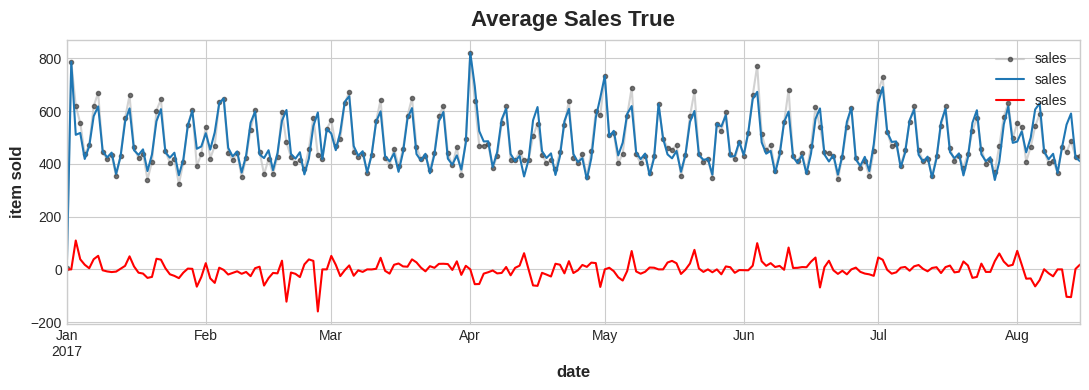

In [42]:
# plot the total average sales of y vs yhat
y_pred = pd.DataFrame(yhat, columns = y.columns, index = X.index)
avg_sale_pred = y_pred.stack(['store_nbr', 'family']).groupby('date').mean()
avg_sale_y = y.stack(['store_nbr', 'family']).groupby('date').mean()

y_resi = (y - yhat)
total_avg_resi = y_resi.stack(['store_nbr', 'family']).groupby('date').mean()

ax = avg_sale_y.plot(**plot_params, alpha = 0.7, label = 'sales', title = 'Average Sales True', ylabel = 'item sold')
avg_sale_pred.plot(ax = ax, label = 'predicted')
total_avg_resi.plot(ax = ax, label = 'residual', color = 'red')
ax.legend()
plt.show()

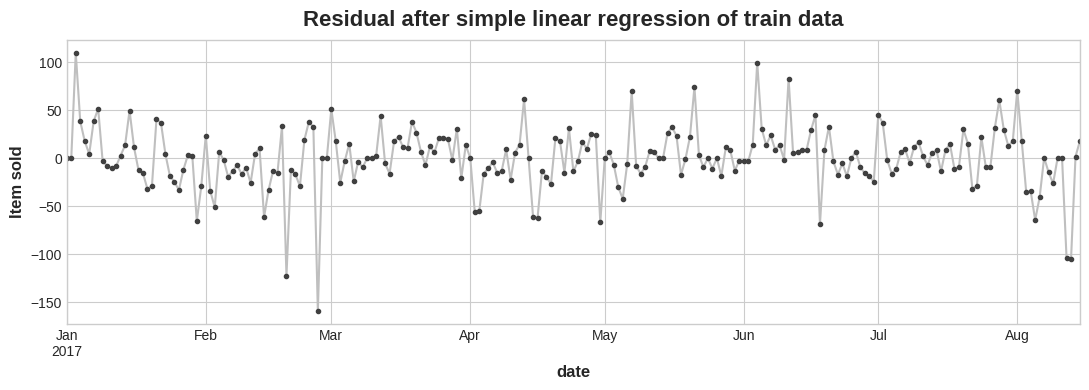

In [43]:
# plot the total average residuals
ax = total_avg_resi.plot(**plot_params, alpha = 1)
ax.set(title = 'Residual after simple linear regression of train data', ylabel = 'Item sold')
plt.show()

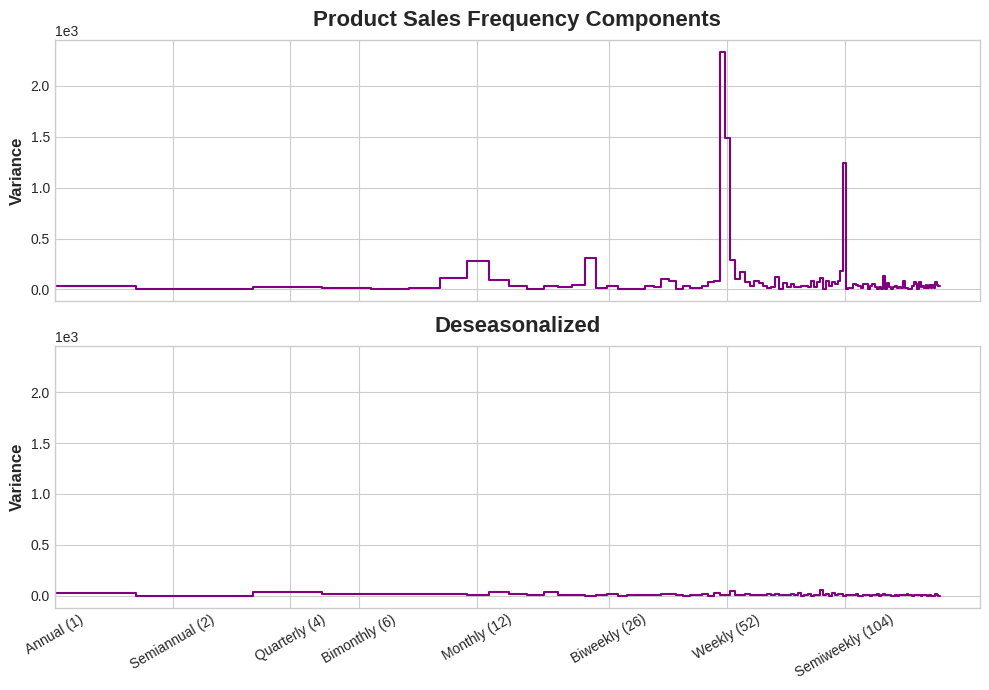

In [44]:
# let's look at the periodogram of the total average sale of y and y_resi
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(avg_sale_y['sales'], ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(total_avg_resi['sales'], ax=ax2);
ax2.set_title("Deseasonalized");
plt.show()

**Note:** Large values in the periodogram are significantly reduced comparing the residual to the original. The simple linear regression model is able to capture the majority of the seasonal variations in average sales.

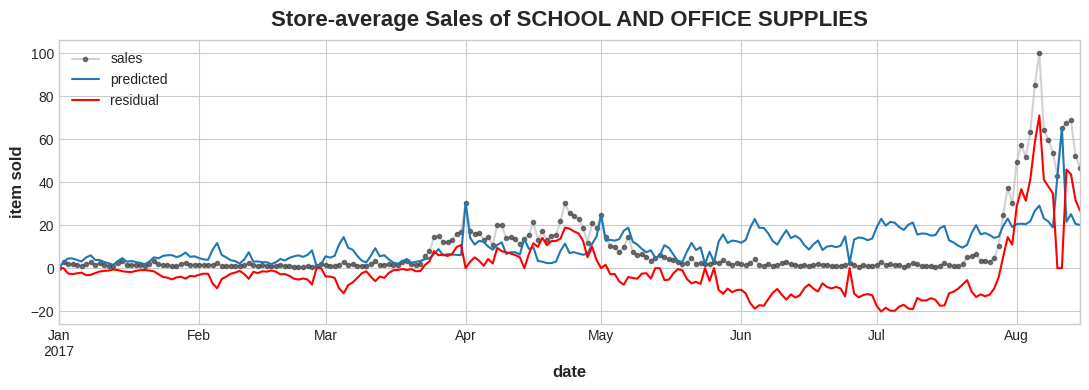

In [45]:
# plot the store-average sales of y vs yhat for one family product of interest
fam = 'SCHOOL AND OFFICE SUPPLIES'

fam_avg_sale_pred = y_pred.stack(['store_nbr']).groupby('date').mean()['sales'][fam]
fam_avg_sale_y = y.stack(['store_nbr']).groupby('date').mean()['sales'][fam]
fam_avg_resi = y_resi.stack(['store_nbr']).groupby('date').mean()['sales'][fam]

ax = fam_avg_sale_y.plot(**plot_params, alpha = 0.7, label = 'sales', title = 'Store-average Sales of %s'%fam, ylabel = 'item sold')
fam_avg_sale_pred.plot(ax = ax, label = 'predicted')
fam_avg_resi.plot(ax = ax, label = 'residual', color = 'red')
ax.legend()
plt.show()

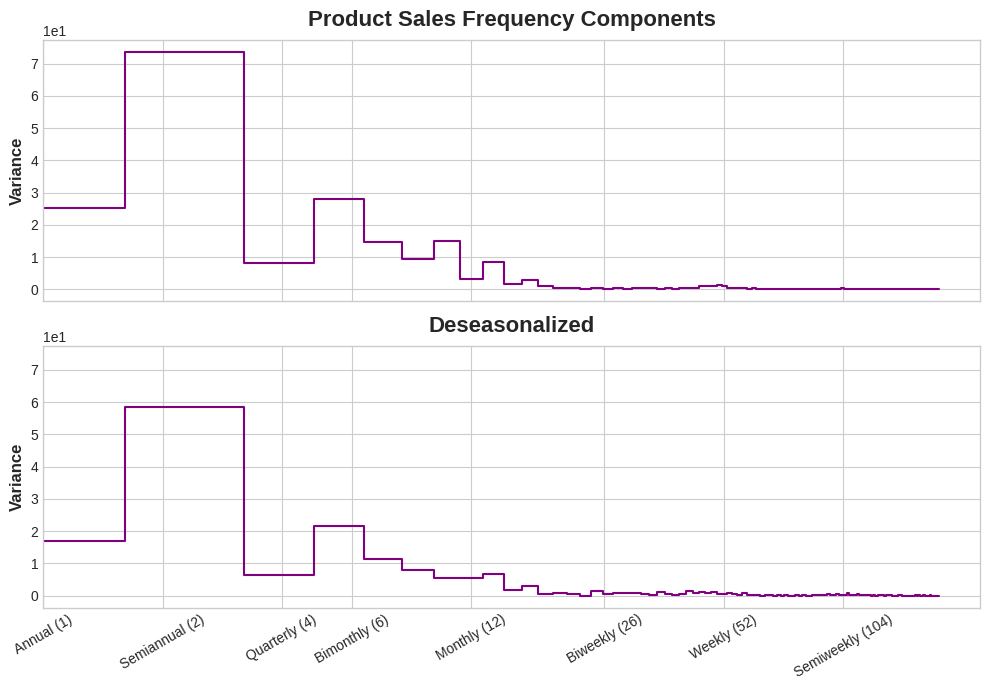

In [46]:
# let's look at the periodogram of the sotre-average sale of y and y_resi for one famlity of interest
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(fam_avg_sale_y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(fam_avg_resi, ax=ax2);
ax2.set_title("Deseasonalized");
plt.show()

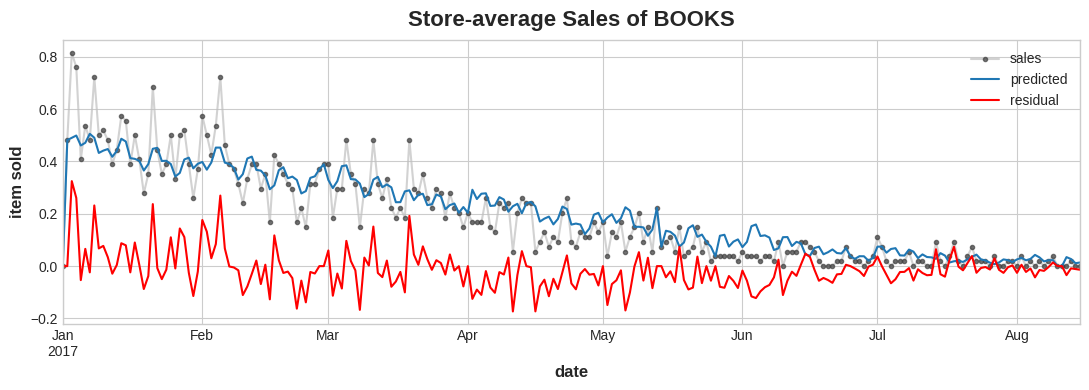

In [47]:
# plot the store-average sales of y vs yhat for one family product of interest
fam = 'BOOKS'

fam_avg_sale_pred = y_pred.stack(['store_nbr']).groupby('date').mean()['sales'][fam]
fam_avg_sale_y = y.stack(['store_nbr']).groupby('date').mean()['sales'][fam]
fam_avg_resi = y_resi.stack(['store_nbr']).groupby('date').mean()['sales'][fam]

ax = fam_avg_sale_y.plot(**plot_params, alpha = 0.7, label = 'sales', title = 'Store-average Sales of %s'%fam, ylabel = 'item sold')
fam_avg_sale_pred.plot(ax = ax, label = 'predicted')
fam_avg_resi.plot(ax = ax, label = 'residual', color = 'red')
ax.legend()
plt.show()

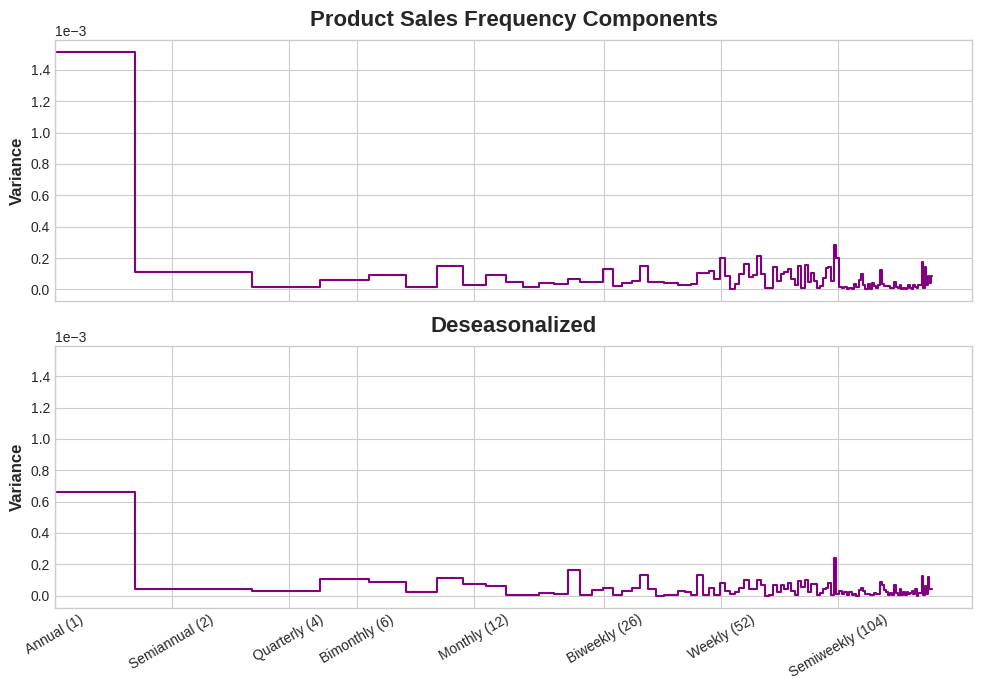

In [48]:
# let's look at the periodogram of the sotre-average sale of y and y_resi for one famlity of interest
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(fam_avg_sale_y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(fam_avg_resi, ax=ax2);
ax2.set_title("Deseasonalized");
plt.show()

**Note:** As expected, the simple linear regression model fails to work for some products which have different trend and seasonal pattern from the majority.

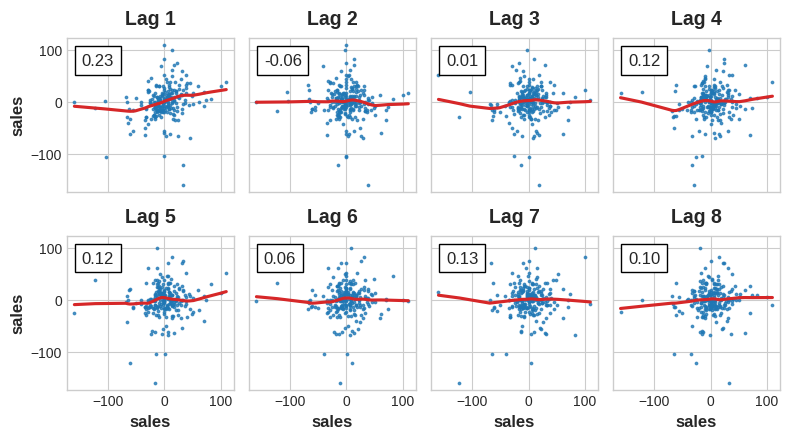

In [49]:
# check residual lag plots and correlogram of total average of residuals

from learntools.time_series.utils import plot_lags
plot_lags(total_avg_resi['sales'], lags = 8, nrows = 2)
plt.show()

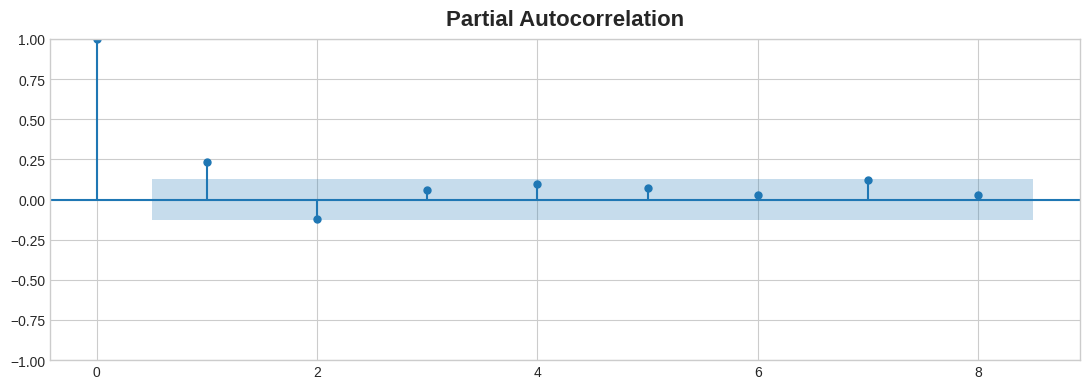

In [50]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(total_avg_resi['sales'], lags=8);
plt.show()

**Note:** The correlogram indicates the first lag might be significant. However, the lag plot suggested non-linear relationship.

## 5.2. Residual Modeling

### 5.2.1. Residual Modeling Feature Preparation

In [51]:
# make lag features using residuals
from learntools.time_series.utils import make_lags
resi_lag1 = make_lags(y_resi['sales'], lags = 1)
resi_lag1 = resi_lag1.stack(['store_nbr','family'])
resi_lag1

y_lag_1
date       store_nbr family                                  
2017-01-02 1         AUTOMOTIVE                  0.000000e+00
                     BABY CARE                   0.000000e+00
                     BEAUTY                     -4.440892e-15
                     BEVERAGES                   0.000000e+00
                     BOOKS                       0.000000e+00
...                                                       ...
2017-08-15 9         POULTRY                    -5.764981e+01
                     PREPARED FOODS              1.025920e+01
                     PRODUCE                    -2.282952e+01
                     SCHOOL AND OFFICE SUPPLIES  1.321411e+02
                     SEAFOOD                    -1.612442e+00

[402732 rows x 1 columns]

In [52]:
X_onp = train_raw.drop('sales', axis = 1).unstack(['store_nbr','family']).stack(['store_nbr','family'])
X_onp_2017 = X_onp.loc['2017']
X_onp_2017

onpromotion
date       store_nbr family                                 
2017-01-01 1         AUTOMOTIVE                            0
                     BABY CARE                             0
                     BEAUTY                                0
                     BEVERAGES                             0
                     BOOKS                                 0
...                                                      ...
2017-08-15 9         POULTRY                               0
                     PREPARED FOODS                        1
                     PRODUCE                             148
                     SCHOOL AND OFFICE SUPPLIES            8
                     SEAFOOD                               0

[404514 rows x 1 columns]

In [53]:
#X_4resi = pd.concat([X_onp_2017,resi_lag1], axis = 1).fillna(0)
X_4resi = X_onp_2017

In [54]:
X_4resi = X_4resi.reorder_levels(['store_nbr','family','date'])
X_4resi

onpromotion
store_nbr family                     date                   
1         AUTOMOTIVE                 2017-01-01            0
          BABY CARE                  2017-01-01            0
          BEAUTY                     2017-01-01            0
          BEVERAGES                  2017-01-01            0
          BOOKS                      2017-01-01            0
...                                                      ...
9         POULTRY                    2017-08-15            0
          PREPARED FOODS             2017-08-15            1
          PRODUCE                    2017-08-15          148
          SCHOOL AND OFFICE SUPPLIES 2017-08-15            8
          SEAFOOD                    2017-08-15            0

[404514 rows x 1 columns]

In [55]:
X_4resi = get_onpromo(X_4resi)
X_4resi

store_nbr  family  onpromotion
date                                     
2017-01-01         1       0            0
2017-01-01         1       1            0
2017-01-01         1       2            0
2017-01-01         1       3            0
2017-01-01         1       4            0
...              ...     ...          ...
2017-08-15         9      28            0
2017-08-15         9      29            1
2017-08-15         9      30          148
2017-08-15         9      31            8
2017-08-15         9      32            0

[404514 rows x 3 columns]

In [56]:
X_4resi = X_4resi.astype('float64')
X_4resi.dtypes

store_nbr      float64
family         float64
onpromotion    float64
dtype: object

In [57]:
y_4resi = y_resi.loc['2017','sales'].stack(['store_nbr','family']).squeeze()
y_4resi

date        store_nbr  family                    
2017-01-01  1          AUTOMOTIVE                    0.000000e+00
                       BABY CARE                     0.000000e+00
                       BEAUTY                       -4.440892e-15
                       BEVERAGES                     0.000000e+00
                       BOOKS                         0.000000e+00
                                                         ...     
2017-08-15  9          POULTRY                       1.093706e+02
                       PREPARED FOODS                4.663977e+01
                       PRODUCE                       1.893344e+02
                       SCHOOL AND OFFICE SUPPLIES    7.042064e+01
                       SEAFOOD                      -3.862329e+00
Length: 404514, dtype: float64

### 5.2.2. Residual Model Fitting

In [58]:
from xgboost import XGBRegressor
xgbr = XGBRegressor().fit(X_4resi, y_4resi)

### 5.2.3. Residual Model Prediction

In [59]:
y_resi_hat = xgbr.predict(X_4resi).clip(0.0)
y_resi_hat

array([ 0.6190173 ,  0.6190173 ,  0.08341755, ..., 15.75486   ,
       37.0829    ,  0.        ], dtype=float32)

In [60]:
yhat = y_pred.stack(['store_nbr','family']).squeeze()
yhat

date        store_nbr  family                    
2017-01-01  1          AUTOMOTIVE                    0.000000e+00
                       BABY CARE                     0.000000e+00
                       BEAUTY                        4.440892e-15
                       BEVERAGES                     0.000000e+00
                       BOOKS                         0.000000e+00
                                                         ...     
2017-08-15  9          POULTRY                       3.287624e+02
                       PREPARED FOODS                1.079132e+02
                       PRODUCE                       2.230395e+03
                       SCHOOL AND OFFICE SUPPLIES    5.057936e+01
                       SEAFOOD                       1.986233e+01
Name: sales, Length: 404514, dtype: float64

In [61]:
y_hat_total = yhat + y_resi_hat
y_hat_total = y_hat_total.unstack(['store_nbr','family'])
y_hat_total

from sklearn.metrics import mean_squared_error, mean_squared_log_error
rmse = mean_squared_error(y['sales'], y_hat_total, squared = False)
rmsle = mean_squared_log_error(y['sales'], y_hat_total, squared = False)
print('Root Mean Square Error of LR is: ', rmse)
print('Root Mean Squared Logarithmic Error of LR is: ', rmsle)

Root Mean Square Error of LR is:  76.99177195868825
Root Mean Squared Logarithmic Error of LR is:  0.39998072032758036


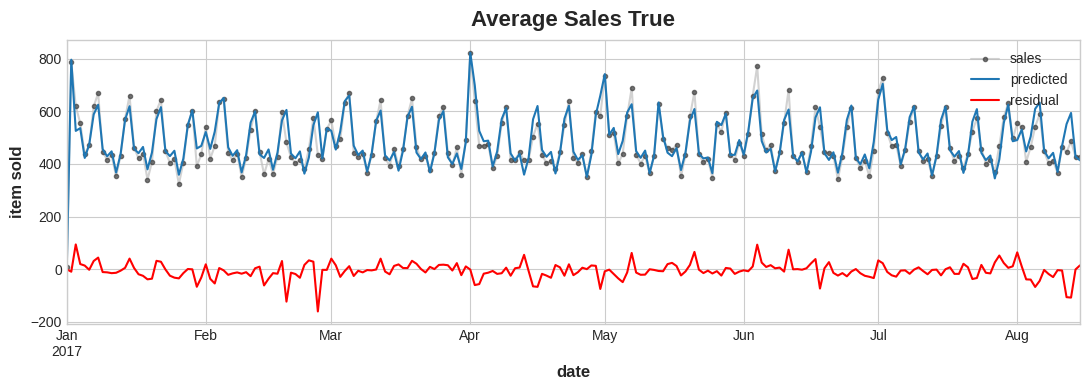

In [62]:
# plot the total average sales of y vs yhat

avg_sale_pred2 = y_hat_total.stack(['store_nbr', 'family']).groupby('date').mean()
avg_sale_y2 = y.stack(['store_nbr', 'family']).groupby('date').mean()

y_resi2 = (y['sales'] - y_hat_total)
total_avg_resi2 = y_resi2.stack(['store_nbr', 'family']).groupby('date').mean()

ax = avg_sale_y2.plot(**plot_params, alpha = 0.7, label = 'sales', title = 'Average Sales True', ylabel = 'item sold')
avg_sale_pred2.plot(ax = ax, label = 'predicted')
total_avg_resi2.plot(ax = ax, label = 'residual', color = 'red')
ax.legend()
plt.show()

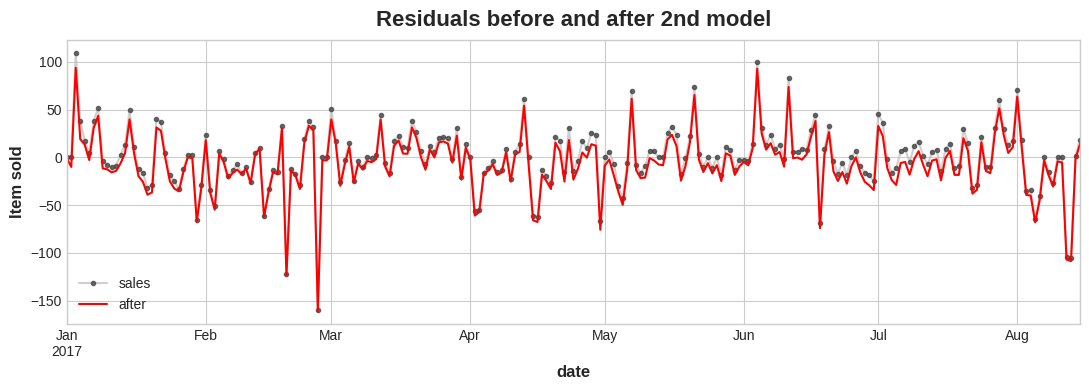

In [63]:
# plot the total average residuals
ax = total_avg_resi.plot(**plot_params, alpha = 0.75)
total_avg_resi2.plot(ax = ax, label = 'after', color = 'red')
ax.set(title = 'Residuals before and after 2nd model', ylabel = 'Item sold')
ax.legend()
plt.show()

**Note:** The improvement is not significant.

# 6. Create Submission

In [64]:
test_raw

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [65]:
X_test = pd.concat([X_1_test, X_2_test], axis = 1).fillna(0)
X_test.columns = X_test.columns.astype(str)

yhat_test = lr.predict(X_test)
y_submit = pd.DataFrame(yhat_test, index = X_test.index, columns = y.columns)
y_submit

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
2017-08-16   4.343378       0.0  3.450092  2394.680125  0.426426   390.465231   
2017-08-17   4.129660       0.0  2.560868  2045.202808  0.082425   335.986151   
2017-08-18   5.836987       0.0  2.567961  2408.256308  0.063186   367.827940   
2017-08-19   4.349701       0.0  3.002273  2422.729392 -0.236652   367.034852   
2017-08-20   1.727270       0.0  1.162044  1025.781286 -0.272501   122.663705   
2017-08-21   4.167832       0.0  3.485006  2365.424060 -0.204956   374.254856   
2017-08-22   4.526007       0.0  3.880988  2345.065615  0.165322   336.196866   
2017-08-23   5.360281       0.0  4.230622  2449.683340  0.286693   396.275599   
2017-08-24   5.876026       0.0  3.505136  2049.857987  0.043145   331.066651   
2017-08-25   7.950710       0.0  3.370709  2338.413441  0.068176   352.840940   
2017-08-26   6.326714       0.0  3.382218  2267.177071 -0.250332   344.819470   
2017-08-27   3.088006       0.0  0.988808   796.021475 -0.347934    97.844546   
2017-08-28   4.631839       0.0  2.854775  2099.832434 -0.345765   352.544645   
2017-08-29   4.119619       0.0  3.093922  2103.247094 -0.002482   323.297308   
2017-08-30   4.405761       0.0  3.669893  2296.628697  0.155327   396.428045   
2017-08-31   4.861590       0.0  3.469456  2034.533175  0.007444   345.598004   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
2017-08-16   17.324467  814.119928  810.391452  138.756602  ...  3.758605   
2017-08-17   20.306121  652.571063  663.434039  116.766776  ...  3.287587   
2017-08-18   22.553495  736.824774  777.971120  178.889972  ...  3.324062   
2017-08-19   12.638809  594.162523  730.989460  137.685037  ...  4.185287   
2017-08-20    1.941097  204.920392  282.411443   58.575835  ...  5.127195   
2017-08-21   13.332433  657.721480  717.098271  145.924425  ...  2.870424   
2017-08-22   15.396670  751.542423  681.324003  132.584243  ...  2.945789   
2017-08-23   17.309719  838.514775  814.750253  134.480283  ...  2.804548   
2017-08-24   21.876522  664.222606  661.746910  109.398646  ...  2.392715   
2017-08-25   25.127026  728.627776  766.193065  169.440844  ...  2.329157   
2017-08-26   15.293543  561.351599  705.898421  127.514146  ...  3.065432   
2017-08-27    3.748450  149.533456  244.341446   49.500416  ...  4.013002   
2017-08-28   13.717760  591.434046  672.231717  140.226750  ...  1.993512   
2017-08-29   14.360720  694.441094  641.670592  132.657358  ...  2.531002   
2017-08-30   15.400282  813.283139  794.872849  142.059868  ...  2.954461   
2017-08-31   19.918598  687.740725  673.078234  124.643251  ...  3.014925   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
2017-08-16  319.307686    331.266492     7.742935                7.636369   
2017-08-17  525.495223    321.039650     6.525765                8.325170   
2017-08-18  298.221108    275.384952     7.285152                7.058629   
2017-08-19  407.516832    536.905078    10.121601               13.349038   
2017-08-20  418.115073    581.040987    10.282097               14.745457   
2017-08-21  314.917794    359.283451     5.937939                7.241276   
2017-08-22  296.955928    352.097954     5.258891                6.801764   
2017-08-23  279.175272    299.935023     7.045408                6.027341   
2017-08-24  480.584378    287.742459     5.920835                6.349227   
2017-08-25  255.621749    240.833018     6.983301                4.854230   
2017-08-26 

In [66]:
X_onp_test = test_raw.drop('id', axis = 1).unstack(['store_nbr','family']).stack(['store_nbr','family'])
X_onp_test_2017 = X_onp_test.loc['2017']
X_4resi_test = X_onp_test_2017.reorder_levels(['store_nbr','family','date'])
X_4resi_test = get_onpromo(X_4resi_test)
X_4resi_test = X_4resi_test.astype('float64')
X_4resi_test

store_nbr  family  onpromotion
date                                      
2017-08-16        1.0     0.0          0.0
2017-08-16        1.0     1.0          0.0
2017-08-16        1.0     2.0          2.0
2017-08-16        1.0     3.0         20.0
2017-08-16        1.0     4.0          0.0
...               ...     ...          ...
2017-08-31        9.0    28.0          1.0
2017-08-31        9.0    29.0          0.0
2017-08-31        9.0    30.0          1.0
2017-08-31        9.0    31.0          9.0
2017-08-31        9.0    32.0          0.0

[28512 rows x 3 columns]

In [67]:
y_submit

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
2017-08-16   4.343378       0.0  3.450092  2394.680125  0.426426   390.465231   
2017-08-17   4.129660       0.0  2.560868  2045.202808  0.082425   335.986151   
2017-08-18   5.836987       0.0  2.567961  2408.256308  0.063186   367.827940   
2017-08-19   4.349701       0.0  3.002273  2422.729392 -0.236652   367.034852   
2017-08-20   1.727270       0.0  1.162044  1025.781286 -0.272501   122.663705   
2017-08-21   4.167832       0.0  3.485006  2365.424060 -0.204956   374.254856   
2017-08-22   4.526007       0.0  3.880988  2345.065615  0.165322   336.196866   
2017-08-23   5.360281       0.0  4.230622  2449.683340  0.286693   396.275599   
2017-08-24   5.876026       0.0  3.505136  2049.857987  0.043145   331.066651   
2017-08-25   7.950710       0.0  3.370709  2338.413441  0.068176   352.840940   
2017-08-26   6.326714       0.0  3.382218  2267.177071 -0.250332   344.819470   
2017-08-27   3.088006       0.0  0.988808   796.021475 -0.347934    97.844546   
2017-08-28   4.631839       0.0  2.854775  2099.832434 -0.345765   352.544645   
2017-08-29   4.119619       0.0  3.093922  2103.247094 -0.002482   323.297308   
2017-08-30   4.405761       0.0  3.669893  2296.628697  0.155327   396.428045   
2017-08-31   4.861590       0.0  3.469456  2034.533175  0.007444   345.598004   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
2017-08-16   17.324467  814.119928  810.391452  138.756602  ...  3.758605   
2017-08-17   20.306121  652.571063  663.434039  116.766776  ...  3.287587   
2017-08-18   22.553495  736.824774  777.971120  178.889972  ...  3.324062   
2017-08-19   12.638809  594.162523  730.989460  137.685037  ...  4.185287   
2017-08-20    1.941097  204.920392  282.411443   58.575835  ...  5.127195   
2017-08-21   13.332433  657.721480  717.098271  145.924425  ...  2.870424   
2017-08-22   15.396670  751.542423  681.324003  132.584243  ...  2.945789   
2017-08-23   17.309719  838.514775  814.750253  134.480283  ...  2.804548   
2017-08-24   21.876522  664.222606  661.746910  109.398646  ...  2.392715   
2017-08-25   25.127026  728.627776  766.193065  169.440844  ...  2.329157   
2017-08-26   15.293543  561.351599  705.898421  127.514146  ...  3.065432   
2017-08-27    3.748450  149.533456  244.341446   49.500416  ...  4.013002   
2017-08-28   13.717760  591.434046  672.231717  140.226750  ...  1.993512   
2017-08-29   14.360720  694.441094  641.670592  132.657358  ...  2.531002   
2017-08-30   15.400282  813.283139  794.872849  142.059868  ...  2.954461   
2017-08-31   19.918598  687.740725  673.078234  124.643251  ...  3.014925   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
2017-08-16  319.307686    331.266492     7.742935                7.636369   
2017-08-17  525.495223    321.039650     6.525765                8.325170   
2017-08-18  298.221108    275.384952     7.285152                7.058629   
2017-08-19  407.516832    536.905078    10.121601               13.349038   
2017-08-20  418.115073    581.040987    10.282097               14.745457   
2017-08-21  314.917794    359.283451     5.937939                7.241276   
2017-08-22  296.955928    352.097954     5.258891                6.801764   
2017-08-23  279.175272    299.935023     7.045408                6.027341   
2017-08-24  480.584378    287.742459     5.920835                6.349227   
2017-08-25  255.621749    240.833018     6.983301                4.854230   
2017-08-26 

In [68]:
y_submit_resi = xgbr.predict(X_4resi_test).clip(0.0)
y_submit = y_submit.stack(['store_nbr','family']).squeeze()
y_submit_total = y_submit_resi + y_submit
y_submit_total = y_submit_total.unstack(['store_nbr','family'])
y_submit_total

store_nbr           1                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
2017-08-16   4.962396  0.619017  5.886718  2394.680125  2.114280   390.465231   
2017-08-17   4.748677  0.619017  3.616142  2045.202808  1.770278   336.315871   
2017-08-18   6.456005  0.619017  3.623234  2408.256308  1.751039   368.948320   
2017-08-19   4.968718  0.619017  4.057547  2422.729392  1.451202   369.265781   
2017-08-20   2.346288  0.619017  2.217318  1025.781286  1.415353   122.663705   
2017-08-21   4.786850  0.619017  4.540279  2365.424060  1.482898   375.375236   
2017-08-22   5.145024  0.619017  3.964405  2345.065615  1.853175   336.196866   
2017-08-23   5.979298  0.619017  5.285896  2522.057783  1.974546   403.085998   
2017-08-24   6.495043  0.619017  3.588554  2187.947434  1.730998   331.066651   
2017-08-25   8.569728  0.619017  3.454127  2401.269905  1.756030   352.840940   
2017-08-26   6.945732  0.619017  4.437492  2330.033536  1.437521   344.819470   
2017-08-27   3.707023  0.619017  2.044082   847.746031  1.339920    97.844546   
2017-08-28   5.250856  0.619017  3.910049  2183.453177  1.342089   352.544645   
2017-08-29   4.738636  0.619017  4.149195  2186.867837  1.685371   323.297308   
2017-08-30   5.024778  0.619017  3.753311  2343.013711  1.843180   396.757765   
2017-08-31   5.480607  0.619017  4.524730  2103.863581  1.695297   345.598004   

store_nbr                                                   ...         9  \
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
2017-08-16   18.498421  836.057877  925.370868  139.192911  ...  3.758605   
2017-08-17   21.480074  652.571063  663.434039  117.581825  ...  3.287587   
2017-08-18   23.727449  736.824774  777.971120  208.324010  ...  3.324062   
2017-08-19   13.812762  594.162523  730.989460  139.844941  ...  4.185287   
2017-08-20    3.115051  204.920392  282.411443   60.735739  ...  5.127195   
2017-08-21   14.506386  657.721480  717.098271  146.739474  ...  2.870424   
2017-08-22   16.570623  751.542423  681.324003  133.399292  ...  2.945789   
2017-08-23   18.483673  838.514775  814.750253  139.075490  ...  2.804548   
2017-08-24   23.050476  664.222606  661.746910  113.993852  ...  2.392715   
2017-08-25   26.300980  728.627776  766.193065  198.874882  ...  2.329157   
2017-08-26   16.467497  561.351599  705.898421  128.605621  ...  3.065432   
2017-08-27    4.922404  149.533456  244.341446   51.660320  ...  4.013002   
2017-08-28   14.891714  591.434046  672.231717  142.381946  ...  1.993512   
2017-08-29   15.534674  694.441094  641.670592  133.472408  ...  2.531002   
2017-08-30   16.574236  813.283139  794.872849  143.098918  ...  2.954461   
2017-08-31   21.092552  687.740725  673.078234  125.682301  ...  3.014925   

store_nbr                                                                  \
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
2017-08-16  319.307686    345.763176     7.742935                7.636369   
2017-08-17  539.047822    321.413441     6.525765                8.325170   
2017-08-18  298.221108    275.384952     7.285152                7.058629   
2017-08-19  407.516832    540.797175    10.121601               13.349038   
2017-08-20  418.115073    587.362556    10.282097               14.745457   
2017-08-21  314.917794    367.245432     5.937939                7.241276   
2017-08-22  296.955928    360.059935     5.258891                6.801764   
2017-08-23  279.175272    308.478116     7.045408                6.027341   
2017-08-24  489.351394    295.704441     5.920835                6.349227   
2017-08-25  255.621749    240.833018     6.983301                4.854230   
2017-08-26  370.398451    508.089914    10.193928               11.069692   
2017-08-27  387.812615    551.331409    10.673216               12.602753   
2017-08-28  294.649074    337.012906     6.559795                5.555156   

In [69]:
y_submit = y_submit_total.stack(['store_nbr', 'family']).to_frame()

In [70]:
y_submit.rename(columns = {0:'sales'}, inplace = True)
y_submit

sales
           store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     4.962396
                     BABY CARE                      0.619017
                     BEAUTY                         5.886718
                     BEVERAGES                   2394.680125
                     BOOKS                          2.114280
...                                                      ...
2017-08-31 9         POULTRY                      357.400388
                     PREPARED FOODS               101.570046
                     PRODUCE                     1233.968735
                     SCHOOL AND OFFICE SUPPLIES   112.206150
                     SEAFOOD                       17.109138

[28512 rows x 1 columns]

In [71]:
y_submit.index.names = ['date','store_nbr', 'family']
y_submit.index.names

FrozenList(['date', 'store_nbr', 'family'])

In [72]:
y_submit = y_submit.reorder_levels(['store_nbr','family','date'])
y_submit

sales
store_nbr family                     date                   
1         AUTOMOTIVE                 2017-08-16     4.962396
          BABY CARE                  2017-08-16     0.619017
          BEAUTY                     2017-08-16     5.886718
          BEVERAGES                  2017-08-16  2394.680125
          BOOKS                      2017-08-16     2.114280
...                                                      ...
9         POULTRY                    2017-08-31   357.400388
          PREPARED FOODS             2017-08-31   101.570046
          PRODUCE                    2017-08-31  1233.968735
          SCHOOL AND OFFICE SUPPLIES 2017-08-31   112.206150
          SEAFOOD                    2017-08-31    17.109138

[28512 rows x 1 columns]

In [73]:
y_submit = y_submit.join(test_raw.id).reindex(columns=['id', 'sales'])

In [74]:
test_raw.id

store_nbr  family      date      
1          AUTOMOTIVE  2017-08-16    3000888
                       2017-08-17    3002670
                       2017-08-18    3004452
                       2017-08-19    3006234
                       2017-08-20    3008016
                                      ...   
9          SEAFOOD     2017-08-27    3022271
                       2017-08-28    3024053
                       2017-08-29    3025835
                       2017-08-30    3027617
                       2017-08-31    3029399
Name: id, Length: 28512, dtype: int64

In [75]:
y_submit

id        sales
store_nbr family                     date                            
1         AUTOMOTIVE                 2017-08-16  3000888     4.962396
          BABY CARE                  2017-08-16  3000889     0.619017
          BEAUTY                     2017-08-16  3000890     5.886718
          BEVERAGES                  2017-08-16  3000891  2394.680125
          BOOKS                      2017-08-16  3000892     2.114280
...                                                  ...          ...
9         POULTRY                    2017-08-31  3029395   357.400388
          PREPARED FOODS             2017-08-31  3029396   101.570046
          PRODUCE                    2017-08-31  3029397  1233.968735
          SCHOOL AND OFFICE SUPPLIES 2017-08-31  3029398   112.206150
          SEAFOOD                    2017-08-31  3029399    17.109138

[28512 rows x 2 columns]

In [76]:
y_submit.to_csv('submission.csv', index=False)